In [1]:
from Feed_Forward_NN import *
#from train_fn import *
from activation_fns_and_grads import *
from loss_fns_with_regularization import *
from optimizers_with_regularization import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import wandb

In [2]:
!wandb login

wandb: Currently logged in as: rayanz (use `wandb login --relogin` to force relogin)


In [3]:
wandb.init(project='Fashion MNIST_sweep2')

wandb: Currently logged in as: rayanz (use `wandb login --relogin` to force relogin)


In [4]:
train_set = torchvision.datasets.FashionMNIST(
    root=''
    ,train=True
    ,download=True
    
)
test_set = torchvision.datasets.FashionMNIST(
    root=''
    ,train=False
    ,download=True
    
)

In [5]:
X_train = np.array(train_set.data)

Y_train = np.array(train_set.targets)

Y_train=Y_train.reshape(-1,1).T

X_train = X_train.reshape(X_train.shape[0],-1).T

X_train, X_val, Y_train, Y_val = train_val_split(X_train, Y_train, val_size=0.1, random_state=42)

In [6]:
# Prior to this define the model
def train(model,
      X_train = X_train,
      Y_train = Y_train,
      X_val = X_val,
      Y_val = Y_val,
      output_activation = "softmax",
      output_loss_fn = "cross_entropy",
      epochs = 50, 
      optimizer_name='adam',
      l2_lambd =0.05,
      learning_rate = 0.0002,
      lr_schedule = 0.4,
      batch_size = 512,
      print_cost = True, 
      val = True):
    
    train_costs_batches = []
    train_accuracy_batches = []
    
    train_costs=[]
    train_accuracy = []
    val_costs = []
    val_accuracy = []
    
    if optimizer_name=='sgd':
        optimizer = stochastic_gradient_descent(learning_rate=learning_rate , l2_lambd=l2_lambd)
    elif optimizer_name=='momentum':
        optimizer = momentum_gradient_descent(params=model.params,learning_rate= learning_rate , l2_lambd=l2_lambd)
    elif optimizer_name=='rmsprop':
        optimizer = rms_prop(params=model.params,learning_rate= learning_rate , l2_lambd=l2_lambd)
    elif optimizer_name=='adam':
        optimizer = adam(params = model.params, learning_rate= learning_rate , l2_lambd=l2_lambd)
    elif optimizer_name== 'nesterov':
        optimizer = nesterov_gradient_descent(params = model.params, learning_rate= learning_rate , l2_lambd=l2_lambd)
    elif optimizer_name=='nadam':
        optimizer = nadam(params = model.params, learning_rate= learning_rate, beta1=0.9, beta2=0.999 , l2_lambd=l2_lambd)
        
    if batch_size==None:
        batch_size = X_train.shape[1]
        
    for i in range(1,epochs+1):
        if i%10==0:
            optimizer.lr=optimizer.lr * lr_schedule
        '''decay = 0.001
        optimizer.lr=optimizer.lr * 1/(1 + decay * i)'''
        
        mini_batches = create_mini_batches(X_train, Y_train, batch_size)
        no_batches = len(mini_batches)
        
        epoch_loss=0
        epoch_correct=0
        
        
        for j , mini_batch in enumerate(mini_batches,1):
            X_mini, Y_mini = mini_batch
            bs = X_mini.shape[1]
            if bs==0:
                break
            
            # Forward Propagation
            XL = model.forward_prop(X_mini) ## final layer output w/o activation
            Y_pred = act_fn(XL,output_activation)
            
            # Compute cost
            batch_cost = cost_fn(model.params,Y_mini,Y_pred, l2_lambd=l2_lambd, output_activation=output_activation, loss_fn=output_loss_fn)
            batch_correct = np.sum(onehot_to_class(Y_pred)==Y_mini)
            
            epoch_loss += batch_cost*bs
            epoch_correct += batch_correct
            
            # Backward propagation
            ## look forward step
            if optimizer_name=='nesterov' or optimizer_name=='nadam':
                optimizer.update_params_prior_grad(model)
            
            dZ=output_exc_act_grad(Y_mini,Y_pred,output_activation=output_activation,loss_fn=output_loss_fn,classes=model.output_nodes)

            model.backward_prop(dZ)

            # Update parameters.
            if optimizer_name== 'nesterov' or optimizer_name=='nadam':
                optimizer.update_params_after_grad(model)
            else:
                optimizer.update_params(model)

            # Print the cost every 100 training batch
            if j % 100 == 0:
                train_costs_batches.append(batch_cost)
                train_accuracy_batches.append(batch_correct/Y_mini.shape[1])
        
        epoch_loss = epoch_loss / X_train.shape[1]
        epoch_correct = epoch_correct / X_train.shape[1]
        
        train_costs.append(epoch_loss)
        train_accuracy.append(epoch_correct)
        wandb.log({'epoch': i,'train loss': epoch_loss,'train accuracy': epoch_correct})
        if val :
            val_acc,val_loss=accuracy_loss(model,X_val,Y_val,output_activation=output_activation,output_loss_fn=output_loss_fn)
            val_costs.append(val_loss)
            val_accuracy.append(val_acc)
            
            wandb.log({'val loss': val_loss,'val accuracy': val_acc})
            if print_cost:
                print("val cost for epoch ", i , "= ",val_loss)
                print("val accuracy for epoch ", i , "= ",val_acc)
                print("train cost for epoch ", i , "= ",epoch_loss)
                print("train accuracy for epoch ", i , "= ",epoch_correct)
                print("")
            
    # plot the cost per 100 batches
    plt.plot(np.squeeze(train_costs_batches))
    plt.plot(np.squeeze(train_accuracy_batches))
    plt.ylabel('train_costs_batches')
    plt.xlabel('batches (per 100)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    


In [7]:
def layers_config_str(s):
    l=list(map(int, s.split('-')))
    return l

In [8]:
def sp_train():
    config_defaults = {
        'epochs': 5,
        'hidden_layers_config':'32' ,
        'L2_regularization': 0.0005,
        'dropout':0.8,
        'learning_rate': 1e-4,
        'lr_schedule': 1,
        'optimizer': 'adam',
        'batch_size': 128,
        'weight_initialization': 'xavier' ,
        'activation_fns': 'relu'
    }
    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    run_name="ep:["+str(config.epochs)+"] hl:["+config.hidden_layers_config+"] lr:["+str(config.learning_rate)+"] op:["+config.optimizer+"] bs:["+str(config.batch_size)+"] ac:["+config.activation_fns+"] L2:["+str(config.L2_regularization)+"] dp:["+str(config.dropout)+"] lr_sc:["+str(config.lr_schedule)+"]"
    wandb.run.name=run_name
    #wandb.init(config=config_defaults, name= run_name)
    
    
    
    nn=FeedForward_NN(input_features= 784, 
                  output_nodes=10, 
                  hidden_layers_dims=layers_config_str(config.hidden_layers_config),
                  act_fn=config.activation_fns,
                  dropout = config.dropout,
                  initialization=config.weight_initialization)
    
    train(model=nn,
          X_train = X_train,
          Y_train = Y_train,
          X_val = X_val,
          Y_val = Y_val,
          output_activation = "softmax",
          output_loss_fn = "cross_entropy",
          epochs = config.epochs, 
          optimizer_name= config.optimizer,
          l2_lambd = config.L2_regularization,
          learning_rate = config.learning_rate,
          lr_schedule = config.lr_schedule,
          batch_size = config.batch_size,
          print_cost = True, 
          val = True)

In [9]:
sweep_config = {
    'method': 'grid', 
    'metric': {
      'name': 'val accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values':[15]
        },
        'hidden_layers_config': {
            'values': ['256',
                       '512'
                       ]
        },
        'L2_regularization': {
            'values':[0.0005, 0.05] 
        },
        'dropout':{
            'values':[0.8,0.7]
        },
        'learning_rate':{
            'values': [1e-4,2e-4]
        },
        'optimizer': {
            'values':['adam','nadam']
        },
        'batch_size': {
            'values':[256]
        },
        'weight_initialization': {
            'values':['xavier'] 
        },
        'activation_fns': {
            'values':['relu']
        },
        'lr_schedule': {
            'values':[1,0.5]
        }
    }
}

In [10]:
sweep_id = wandb.sweep(sweep_config, project="Sweep_2")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: ihmhnzeq
Sweep URL: https://wandb.ai/rayanz/Sweep_2/sweeps/ihmhnzeq


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: 6nwowmkc with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 1
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.47128427076313834
val accuracy for epoch  1 =  0.8316666666666667
train cost for epoch  1 =  0.6562578910053597
train accuracy for epoch  1 =  0.7744814814814814

val cost for epoch  2 =  0.4062771042441113
val accuracy for epoch  2 =  0.852
train cost for epoch  2 =  0.42630612724285644
train accuracy for epoch  2 =  0.8532037037037037

val cost for epoch  3 =  0.3913974378558151
val accuracy for epoch  3 =  0.8558333333333333
train cost for epoch  3 =  0.38419197858221077
train accuracy for epoch  3 =  0.8657777777777778

val cost for epoch  4 =  0.3713690240056484
val accuracy for epoch  4 =  0.868
train cost for epoch  4 =  0.3554635779461463
train accuracy for epoch  4 =  0.8760555555555556

val cost for epoch  5 =  0.3600946559161778
val accuracy for epoch  5 =  0.8691666666666666
train cost for epoch  5 =  0.33785572855221013
train accuracy for epoch  5 =  0.8822592592592593

val cost for epoch  6 =  0.3564500713854231
val accuracy for epoch  6 =  0.87

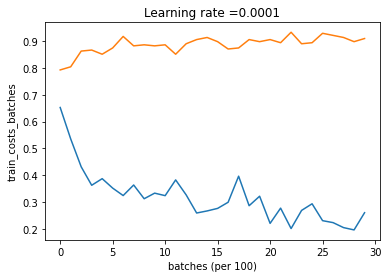

epoch,15
train loss,0.25171
train accuracy,0.91039
_runtime,136
_timestamp,1615558612
_step,29
val loss,0.33207
val accuracy,0.881


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇▇█████
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▃▃▃▃▂▂▂▁▂▁▂▁
val accuracy,▁▄▄▆▆▆▇▇▇▆█▇▇▇█


wandb: Agent Starting Run: godw8apj with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 1
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6615609870334062
val accuracy for epoch  1 =  0.7618333333333334
train cost for epoch  1 =  0.9556639268396293
train accuracy for epoch  1 =  0.6933518518518519

val cost for epoch  2 =  0.5465274048014741
val accuracy for epoch  2 =  0.812
train cost for epoch  2 =  0.5757448105046779
train accuracy for epoch  2 =  0.8045555555555556

val cost for epoch  3 =  0.4995745709346002
val accuracy for epoch  3 =  0.8286666666666667
train cost for epoch  3 =  0.5061469228378742
train accuracy for epoch  3 =  0.8293888888888888

val cost for epoch  4 =  0.46939318499352817
val accuracy for epoch  4 =  0.8373333333333334
train cost for epoch  4 =  0.472064595087814
train accuracy for epoch  4 =  0.8402592592592593

val cost for epoch  5 =  0.44539332629789147
val accuracy for epoch  5 =  0.8431666666666666
train cost for epoch  5 =  0.4464253763978438
train accuracy for epoch  5 =  0.8504259259259259

val cost for epoch  6 =  0.43203213209451163
val accuracy for epoch

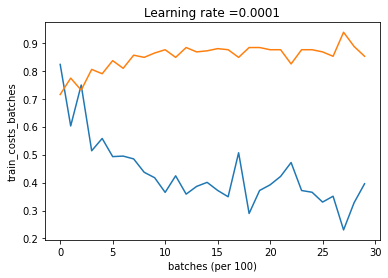

epoch,15
train loss,0.34153
train accuracy,0.88341
_runtime,151
_timestamp,1615558769
_step,29
val loss,0.37996
val accuracy,0.865


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇██████
_runtime,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▃▃▂▂▂▂▁▂▁▁▁▁
val accuracy,▁▄▅▆▆▇▇▇▇██████


wandb: Agent Starting Run: k64xvdrb with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.48251166822084224
val accuracy for epoch  1 =  0.828
train cost for epoch  1 =  0.6616033359475718
train accuracy for epoch  1 =  0.7735740740740741

val cost for epoch  2 =  0.42329248376957596
val accuracy for epoch  2 =  0.848
train cost for epoch  2 =  0.4298206995293496
train accuracy for epoch  2 =  0.8530740740740741

val cost for epoch  3 =  0.3806785527202825
val accuracy for epoch  3 =  0.8616666666666667
train cost for epoch  3 =  0.3820817236491561
train accuracy for epoch  3 =  0.8676666666666667

val cost for epoch  4 =  0.379958988312073
val accuracy for epoch  4 =  0.8661666666666666
train cost for epoch  4 =  0.35497179173694104
train accuracy for epoch  4 =  0.8759259259259259

val cost for epoch  5 =  0.3567863658976773
val accuracy for epoch  5 =  0.8688333333333333
train cost for epoch  5 =  0.3371867935604812
train accuracy for epoch  5 =  0.881462962962963

val cost for epoch  6 =  0.3565475918176703
val accuracy for epoch  6 =  0.87
tr

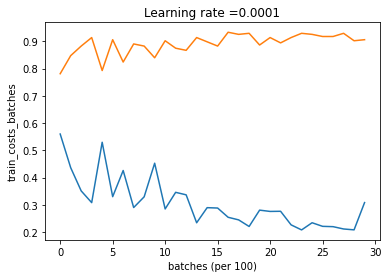

epoch,15
train loss,0.23993
train accuracy,0.91524
_runtime,126
_timestamp,1615558902
_step,29
val loss,0.31591
val accuracy,0.88567


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▃▂▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▆▆▆▇▇▇▇██████
_runtime,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▄▄▃▃▃▂▂▂▁▁▁▁▁
val accuracy,▁▃▅▆▆▆▆▆▇▇█▇███


wandb: Agent Starting Run: uwo05mzk with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6459809048850269
val accuracy for epoch  1 =  0.7723333333333333
train cost for epoch  1 =  0.9470628632200194
train accuracy for epoch  1 =  0.6945740740740741

val cost for epoch  2 =  0.5537173758410555
val accuracy for epoch  2 =  0.8055
train cost for epoch  2 =  0.5734610701718023
train accuracy for epoch  2 =  0.8066666666666666

val cost for epoch  3 =  0.49926255680954834
val accuracy for epoch  3 =  0.8253333333333334
train cost for epoch  3 =  0.5062993152582435
train accuracy for epoch  3 =  0.8301851851851851

val cost for epoch  4 =  0.46574954836212745
val accuracy for epoch  4 =  0.837
train cost for epoch  4 =  0.4720822644481456
train accuracy for epoch  4 =  0.8408703703703704

val cost for epoch  5 =  0.44871883892139347
val accuracy for epoch  5 =  0.8431666666666666
train cost for epoch  5 =  0.4469917879634833
train accuracy for epoch  5 =  0.8492222222222222

val cost for epoch  6 =  0.4452718089874816
val accuracy for epoch  6 =  0.84

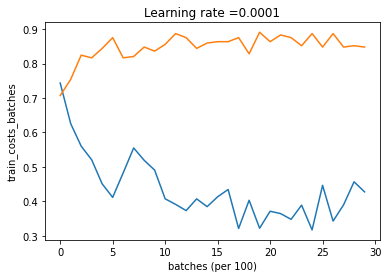

epoch,15
train loss,0.35702
train accuracy,0.87817
_runtime,155
_timestamp,1615559062
_step,29
val loss,0.37939
val accuracy,0.86417


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
train accuracy,▁▅▆▇▇▇▇▇███████
_runtime,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▄▃▃▃▂▂▂▁▁▁▁▁▁
val accuracy,▁▄▅▆▆▆▇▇███████


wandb: Agent Starting Run: 4kbwiy2f with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 1
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.4523207285094416
val accuracy for epoch  1 =  0.8365
train cost for epoch  1 =  0.5980658737700878
train accuracy for epoch  1 =  0.7908888888888889

val cost for epoch  2 =  0.3877283277996886
val accuracy for epoch  2 =  0.8563333333333333
train cost for epoch  2 =  0.41427954043359355
train accuracy for epoch  2 =  0.8556851851851852

val cost for epoch  3 =  0.4039789685804157
val accuracy for epoch  3 =  0.8588333333333333
train cost for epoch  3 =  0.376958118931048
train accuracy for epoch  3 =  0.8660925925925926

val cost for epoch  4 =  0.37256449794068686
val accuracy for epoch  4 =  0.865
train cost for epoch  4 =  0.3547246257780822
train accuracy for epoch  4 =  0.8750555555555556

val cost for epoch  5 =  0.3634757091627942
val accuracy for epoch  5 =  0.8645
train cost for epoch  5 =  0.3335725066608621
train accuracy for epoch  5 =  0.8802407407407408

val cost for epoch  6 =  0.3560966468004343
val accuracy for epoch  6 =  0.8726666666666667

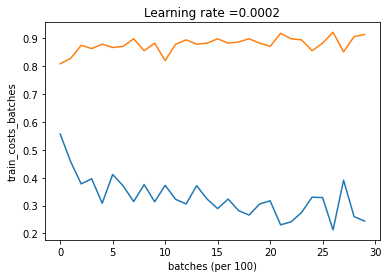

epoch,15
train loss,0.25805
train accuracy,0.90772
_runtime,131
_timestamp,1615559200
_step,29
val loss,0.36281
val accuracy,0.87433


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▆▆▆▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▃▅▂▂▁▁▁▂▂▁▁▁▂▂
val accuracy,▁▄▅▆▆▇▇█▇▇▇████


wandb: Agent Starting Run: mycz4id7 with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 1
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5696494908844406
val accuracy for epoch  1 =  0.802
train cost for epoch  1 =  0.7781694345431738
train accuracy for epoch  1 =  0.7381296296296296

val cost for epoch  2 =  0.4722209130499903
val accuracy for epoch  2 =  0.833
train cost for epoch  2 =  0.505629905868655
train accuracy for epoch  2 =  0.8275185185185185

val cost for epoch  3 =  0.4449462184124427
val accuracy for epoch  3 =  0.8431666666666666
train cost for epoch  3 =  0.4532957173944612
train accuracy for epoch  3 =  0.8457222222222223

val cost for epoch  4 =  0.42320747733662506
val accuracy for epoch  4 =  0.8523333333333334
train cost for epoch  4 =  0.42242998602413023
train accuracy for epoch  4 =  0.8560185185185185

val cost for epoch  5 =  0.4082615058295679
val accuracy for epoch  5 =  0.8563333333333333
train cost for epoch  5 =  0.3973488181353029
train accuracy for epoch  5 =  0.8639074074074075

val cost for epoch  6 =  0.3969462925406987
val accuracy for epoch  6 =  0.85966

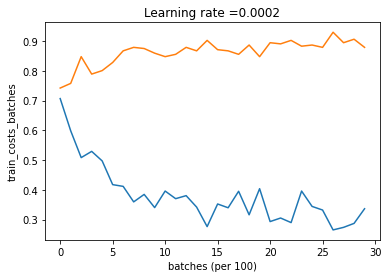

epoch,15
train loss,0.29753
train accuracy,0.8972
_runtime,152
_timestamp,1615559357
_step,29
val loss,0.3451
val accuracy,0.87417


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇██████
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▃▃▃▂▂▂▂▁▁▁▁▁
val accuracy,▁▄▅▆▆▆▇▇▇▇█████


wandb: Agent Starting Run: 8gx48syb with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.4359673264208475
val accuracy for epoch  1 =  0.8443333333333334
train cost for epoch  1 =  0.5938324549909688
train accuracy for epoch  1 =  0.7935

val cost for epoch  2 =  0.39911779955178994
val accuracy for epoch  2 =  0.8568333333333333
train cost for epoch  2 =  0.4126327054118739
train accuracy for epoch  2 =  0.8555185185185186

val cost for epoch  3 =  0.3746586124152293
val accuracy for epoch  3 =  0.8695
train cost for epoch  3 =  0.3771744936452654
train accuracy for epoch  3 =  0.8664259259259259

val cost for epoch  4 =  0.3652043397948938
val accuracy for epoch  4 =  0.866
train cost for epoch  4 =  0.3490444611701985
train accuracy for epoch  4 =  0.8757407407407407

val cost for epoch  5 =  0.36606227603104835
val accuracy for epoch  5 =  0.8695
train cost for epoch  5 =  0.3354278704922575
train accuracy for epoch  5 =  0.8808703703703704

val cost for epoch  6 =  0.35509538301741794
val accuracy for epoch  6 =  0.875
train cost for epoch  

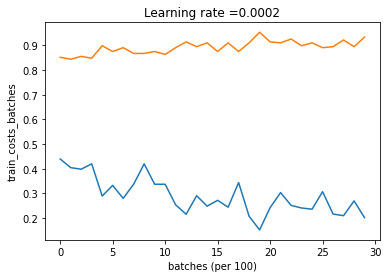

epoch,15
train loss,0.23523
train accuracy,0.91654
_runtime,130
_timestamp,1615559492
_step,29
val loss,0.33692
val accuracy,0.88317


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▄▃▃▃▃▂▂▂▁▁▁▁▁
train accuracy,▁▅▅▆▆▆▆▇▇▇█████
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▄▃▄▃▃▄▂▁▂▂▂▁▂
val accuracy,▁▃▅▅▅▆▆▆▆█▆▇▇██


wandb: Agent Starting Run: tazc8c4m with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5612949850692452
val accuracy for epoch  1 =  0.8071666666666667
train cost for epoch  1 =  0.7676336554960583
train accuracy for epoch  1 =  0.7401851851851852

val cost for epoch  2 =  0.4909569197289059
val accuracy for epoch  2 =  0.823
train cost for epoch  2 =  0.5083942467119659
train accuracy for epoch  2 =  0.8280925925925926

val cost for epoch  3 =  0.4539535502790002
val accuracy for epoch  3 =  0.8418333333333333
train cost for epoch  3 =  0.4525389584177213
train accuracy for epoch  3 =  0.8466851851851852

val cost for epoch  4 =  0.4223854252774574
val accuracy for epoch  4 =  0.854
train cost for epoch  4 =  0.4221112064397448
train accuracy for epoch  4 =  0.8567962962962963

val cost for epoch  5 =  0.4119224183071596
val accuracy for epoch  5 =  0.8521666666666666
train cost for epoch  5 =  0.39760056180346415
train accuracy for epoch  5 =  0.8646111111111111

val cost for epoch  6 =  0.3857204337605278
val accuracy for epoch  6 =  0.86166

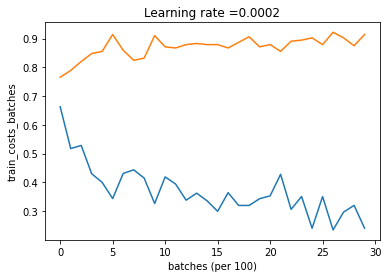

epoch,15
train loss,0.30422
train accuracy,0.89687
_runtime,149
_timestamp,1615559645
_step,29
val loss,0.33943
val accuracy,0.87867


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▅▄▃▂▂▂▂▂▂▁▁▁▁
val accuracy,▁▃▄▆▅▆▆▇▇▇▇██▇█


wandb: Agent Starting Run: hshyfohz with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 1
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.46020114765066533
val accuracy for epoch  1 =  0.8346666666666667
train cost for epoch  1 =  0.6181382360279812
train accuracy for epoch  1 =  0.7873333333333333

val cost for epoch  2 =  0.39644923110995794
val accuracy for epoch  2 =  0.8591666666666666
train cost for epoch  2 =  0.4142146470972971
train accuracy for epoch  2 =  0.8555

val cost for epoch  3 =  0.38099845042812014
val accuracy for epoch  3 =  0.8621666666666666
train cost for epoch  3 =  0.36784241833118664
train accuracy for epoch  3 =  0.8709814814814815

val cost for epoch  4 =  0.37353876089443155
val accuracy for epoch  4 =  0.861
train cost for epoch  4 =  0.3439994560156592
train accuracy for epoch  4 =  0.880462962962963

val cost for epoch  5 =  0.34861198764553425
val accuracy for epoch  5 =  0.8738333333333334
train cost for epoch  5 =  0.325241289312172
train accuracy for epoch  5 =  0.8834814814814815

val cost for epoch  6 =  0.3495255142324246
val accuracy for epoch  6 =  0.8

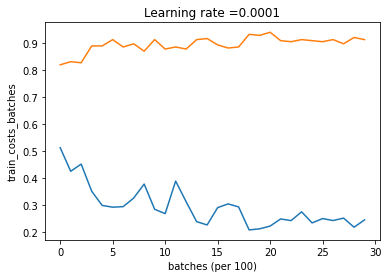

epoch,15
train loss,0.23688
train accuracy,0.91604
_runtime,215
_timestamp,1615559865
_step,29
val loss,0.32312
val accuracy,0.88533


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▆▆▆▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▄▂▂▂▂▂▁▁▁▁▁▁
val accuracy,▁▄▅▅▆▇▇▇▇█▇▇█▇█


wandb: Agent Starting Run: 7syrzgsm with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 1
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5897498185129582
val accuracy for epoch  1 =  0.7935
train cost for epoch  1 =  0.8530509478989626
train accuracy for epoch  1 =  0.725

val cost for epoch  2 =  0.5140737947070291
val accuracy for epoch  2 =  0.8235
train cost for epoch  2 =  0.5351531574920535
train accuracy for epoch  2 =  0.8199074074074074

val cost for epoch  3 =  0.47440538364325996
val accuracy for epoch  3 =  0.834
train cost for epoch  3 =  0.48015292587402264
train accuracy for epoch  3 =  0.8389629629629629

val cost for epoch  4 =  0.4448670492783273
val accuracy for epoch  4 =  0.8463333333333334
train cost for epoch  4 =  0.4481161217523176
train accuracy for epoch  4 =  0.8487407407407408

val cost for epoch  5 =  0.4312530104611348
val accuracy for epoch  5 =  0.8385
train cost for epoch  5 =  0.4252660991817379
train accuracy for epoch  5 =  0.8565555555555555

val cost for epoch  6 =  0.413306986885585
val accuracy for epoch  6 =  0.8516666666666667
train cost for epoch  6 

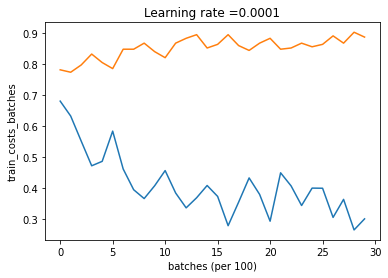

epoch,15
train loss,0.32197
train accuracy,0.89009
_runtime,283
_timestamp,1615560155
_step,29
val loss,0.34846
val accuracy,0.87567


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇▇█████
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▅▄▃▃▂▃▂▂▂▂▁▁▁
val accuracy,▁▄▄▆▅▆▇▆▇▇▇▇▇██


wandb: Agent Starting Run: w2al3cig with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.4511432356380786
val accuracy for epoch  1 =  0.8376666666666667
train cost for epoch  1 =  0.620312319298529
train accuracy for epoch  1 =  0.7843333333333333

val cost for epoch  2 =  0.41466402064799796
val accuracy for epoch  2 =  0.8533333333333334
train cost for epoch  2 =  0.4129844362076686
train accuracy for epoch  2 =  0.8553148148148149

val cost for epoch  3 =  0.362040598957627
val accuracy for epoch  3 =  0.8738333333333334
train cost for epoch  3 =  0.3698923014118741
train accuracy for epoch  3 =  0.8701666666666666

val cost for epoch  4 =  0.3573794875165511
val accuracy for epoch  4 =  0.8721666666666666
train cost for epoch  4 =  0.342338779487724
train accuracy for epoch  4 =  0.880425925925926

val cost for epoch  5 =  0.3679754274657602
val accuracy for epoch  5 =  0.8643333333333333
train cost for epoch  5 =  0.32410056828352135
train accuracy for epoch  5 =  0.8866296296296297

val cost for epoch  6 =  0.3408338676379814
val accuracy 

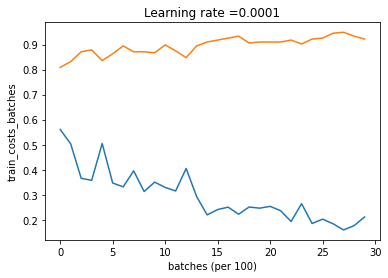

epoch,15
train loss,0.22297
train accuracy,0.9223
_runtime,236
_timestamp,1615560398
_step,29
val loss,0.32856
val accuracy,0.88517


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▄▃▃▃▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▅▆▆▆▆▇▇▇█████
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▄▃▄▃▂▂▃▂▁▂▁▁▂
val accuracy,▁▃▆▆▅▇▇▇▆▇████▇


wandb: Agent Starting Run: 3qanllyj with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5977240209023083
val accuracy for epoch  1 =  0.795
train cost for epoch  1 =  0.8511335598760308
train accuracy for epoch  1 =  0.7233333333333334

val cost for epoch  2 =  0.5095034483517391
val accuracy for epoch  2 =  0.8245
train cost for epoch  2 =  0.5331604138652057
train accuracy for epoch  2 =  0.8197592592592593

val cost for epoch  3 =  0.4635421396084585
val accuracy for epoch  3 =  0.8393333333333334
train cost for epoch  3 =  0.4754696614229572
train accuracy for epoch  3 =  0.8391481481481482

val cost for epoch  4 =  0.44769838439125276
val accuracy for epoch  4 =  0.8413333333333334
train cost for epoch  4 =  0.4443525642403077
train accuracy for epoch  4 =  0.8501296296296297

val cost for epoch  5 =  0.4220303338967325
val accuracy for epoch  5 =  0.8521666666666666
train cost for epoch  5 =  0.422097912769928
train accuracy for epoch  5 =  0.8568518518518519

val cost for epoch  6 =  0.4342117310363348
val accuracy for epoch  6 =  0.84383

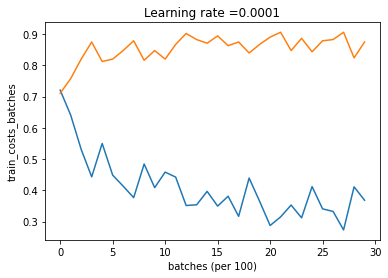

epoch,15
train loss,0.33231
train accuracy,0.88663
_runtime,271
_timestamp,1615560675
_step,29
val loss,0.36215
val accuracy,0.87067


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇███████
_runtime,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▄▃▃▂▂▂▁▁▁▁▁▁
val accuracy,▁▄▅▅▆▆▇▇▇██████


wandb: Agent Starting Run: 4pt90vhb with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 1
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.49901006790519836
val accuracy for epoch  1 =  0.8083333333333333
train cost for epoch  1 =  0.5725418852878679
train accuracy for epoch  1 =  0.7984074074074075

val cost for epoch  2 =  0.4166366614468323
val accuracy for epoch  2 =  0.8486666666666667
train cost for epoch  2 =  0.4026594398386375
train accuracy for epoch  2 =  0.8587222222222223

val cost for epoch  3 =  0.3725406123631734
val accuracy for epoch  3 =  0.8615
train cost for epoch  3 =  0.3670198282382256
train accuracy for epoch  3 =  0.8705925925925926

val cost for epoch  4 =  0.3702266291138563
val accuracy for epoch  4 =  0.8656666666666667
train cost for epoch  4 =  0.3418024963773021
train accuracy for epoch  4 =  0.8782592592592593

val cost for epoch  5 =  0.3750244855237014
val accuracy for epoch  5 =  0.8638333333333333
train cost for epoch  5 =  0.32970308120135566
train accuracy for epoch  5 =  0.882962962962963

val cost for epoch  6 =  0.3626661472368355
val accuracy for epoch

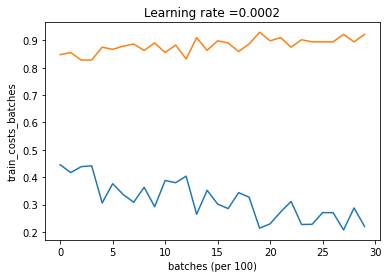

epoch,15
train loss,0.24552
train accuracy,0.91143
_runtime,215
_timestamp,1615560895
_step,29
val loss,0.37168
val accuracy,0.87367


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▄▃▃▃▂▂▂▂▂▁▁▁▁
train accuracy,▁▅▅▆▆▆▇▇▇▇▇████
_runtime,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▄▂▂▃▂▂▂▂▂▂▁▁▁▂
val accuracy,▁▅▆▆▆▇▆▇▇▇▇███▇


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ogf1624b with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 1
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5366027892248368
val accuracy for epoch  1 =  0.8141666666666667
train cost for epoch  1 =  0.7233602560846367
train accuracy for epoch  1 =  0.752462962962963

val cost for epoch  2 =  0.453279871034542
val accuracy for epoch  2 =  0.8395
train cost for epoch  2 =  0.48790289066424797
train accuracy for epoch  2 =  0.8309814814814814

val cost for epoch  3 =  0.420453165302296
val accuracy for epoch  3 =  0.8475
train cost for epoch  3 =  0.43479408765308575
train accuracy for epoch  3 =  0.8520925925925926

val cost for epoch  4 =  0.401234083621612
val accuracy for epoch  4 =  0.8581666666666666
train cost for epoch  4 =  0.4035887344212351
train accuracy for epoch  4 =  0.8620185185185185

val cost for epoch  5 =  0.3955953984671454
val accuracy for epoch  5 =  0.8595
train cost for epoch  5 =  0.3810187723050314
train accuracy for epoch  5 =  0.8683518518518518

val cost for epoch  6 =  0.37695752714900416
val accuracy for epoch  6 =  0.868
train cost fo

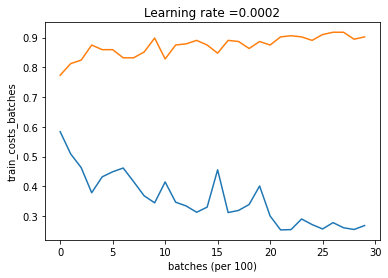

epoch,15
train loss,0.27815
train accuracy,0.90357
_runtime,266
_timestamp,1615561175
_step,29
val loss,0.33931
val accuracy,0.88067


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▆▆▆▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▃▃▃▂▂▂▂▂▂▁▁▁
val accuracy,▁▄▄▆▆▇▇▇▇▇█▇███


wandb: Agent Starting Run: vsp7qhmg with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.4947427052473781
val accuracy for epoch  1 =  0.819
train cost for epoch  1 =  0.5730442888043255
train accuracy for epoch  1 =  0.7971481481481482

val cost for epoch  2 =  0.38603654098211243
val accuracy for epoch  2 =  0.858
train cost for epoch  2 =  0.4030797732858202
train accuracy for epoch  2 =  0.8579814814814815

val cost for epoch  3 =  0.39891746844634407
val accuracy for epoch  3 =  0.8576666666666667
train cost for epoch  3 =  0.36357319490892553
train accuracy for epoch  3 =  0.8708703703703704

val cost for epoch  4 =  0.3736506562340376
val accuracy for epoch  4 =  0.867
train cost for epoch  4 =  0.3463120366246256
train accuracy for epoch  4 =  0.8773703703703704

val cost for epoch  5 =  0.34368785222780174
val accuracy for epoch  5 =  0.875
train cost for epoch  5 =  0.3281619083462337
train accuracy for epoch  5 =  0.8836111111111111

val cost for epoch  6 =  0.3696143961088777
val accuracy for epoch  6 =  0.8665
train cost for epoch  6

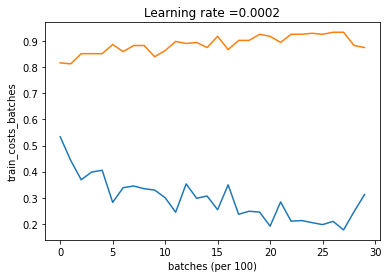

epoch,15
train loss,0.22208
train accuracy,0.92107
_runtime,223
_timestamp,1615561402
_step,29
val loss,0.33255
val accuracy,0.88967


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▅▄▃▃▃▃▂▂▂▁▁▁▁▁
train accuracy,▁▄▅▆▆▆▆▆▇▇█████
_runtime,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▄▄▃▂▃▃▂▃▁▂▁▁▁▂
val accuracy,▁▅▅▆▆▆▆▇▆▇▇████


wandb: Agent Starting Run: p5ze9ulu with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5567550228096131
val accuracy for epoch  1 =  0.8001666666666667
train cost for epoch  1 =  0.7214809475580577
train accuracy for epoch  1 =  0.7531851851851852

val cost for epoch  2 =  0.4509640837785477
val accuracy for epoch  2 =  0.8416666666666667
train cost for epoch  2 =  0.48803044027326237
train accuracy for epoch  2 =  0.8338148148148148

val cost for epoch  3 =  0.4174237389028707
val accuracy for epoch  3 =  0.8538333333333333
train cost for epoch  3 =  0.43402882509660656
train accuracy for epoch  3 =  0.8515370370370371

val cost for epoch  4 =  0.4055540088075661
val accuracy for epoch  4 =  0.8558333333333333
train cost for epoch  4 =  0.40253410108849
train accuracy for epoch  4 =  0.8627222222222222

val cost for epoch  5 =  0.3977789605684518
val accuracy for epoch  5 =  0.8576666666666667
train cost for epoch  5 =  0.3786226732893407
train accuracy for epoch  5 =  0.8701296296296296

val cost for epoch  6 =  0.36598151474298063
val accura

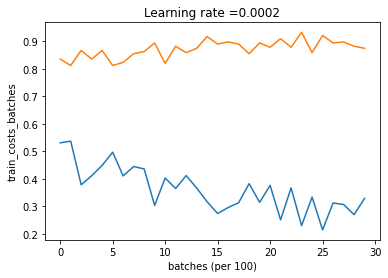

epoch,15
train loss,0.2852
train accuracy,0.90163
_runtime,273
_timestamp,1615561680
_step,29
val loss,0.32696
val accuracy,0.88317


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▃▃▂▂▂▂▁▂▁▁▁▁
val accuracy,▁▄▆▆▆▇▆▇▇█▇████


wandb: Agent Starting Run: v71b5urm with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 1
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.4764755453478411
val accuracy for epoch  1 =  0.8273333333333334
train cost for epoch  1 =  0.6595373689472471
train accuracy for epoch  1 =  0.774537037037037

val cost for epoch  2 =  0.42612334785776973
val accuracy for epoch  2 =  0.8486666666666667
train cost for epoch  2 =  0.43375714581317976
train accuracy for epoch  2 =  0.8490925925925926

val cost for epoch  3 =  0.3965198896957678
val accuracy for epoch  3 =  0.8583333333333333
train cost for epoch  3 =  0.39367248111999814
train accuracy for epoch  3 =  0.8621111111111112

val cost for epoch  4 =  0.3810258411666246
val accuracy for epoch  4 =  0.8653333333333333
train cost for epoch  4 =  0.367372640447156
train accuracy for epoch  4 =  0.8712962962962963

val cost for epoch  5 =  0.3852695889443609
val accuracy for epoch  5 =  0.8596666666666667
train cost for epoch  5 =  0.3507310072719075
train accuracy for epoch  5 =  0.8771111111111111

val cost for epoch  6 =  0.3670391915472106
val accura

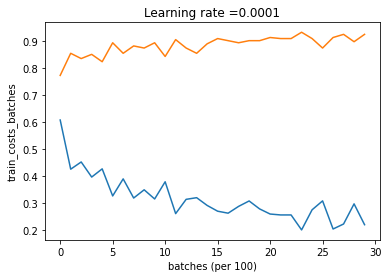

epoch,15
train loss,0.26574
train accuracy,0.90552
_runtime,126
_timestamp,1615561811
_step,29
val loss,0.34129
val accuracy,0.87967


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▆▆▆▇▇▇▇▇▇████
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▃▃▂▂▂▂▁▂▂▁▁▁
val accuracy,▁▄▅▆▅▇▇▇██▇▇█▇█


wandb: Agent Starting Run: ejzbrdaa with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 1
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6742798404377829
val accuracy for epoch  1 =  0.7585
train cost for epoch  1 =  0.9576395140286449
train accuracy for epoch  1 =  0.6890555555555555

val cost for epoch  2 =  0.5542116385278928
val accuracy for epoch  2 =  0.8083333333333333
train cost for epoch  2 =  0.588478195587042
train accuracy for epoch  2 =  0.7994444444444444

val cost for epoch  3 =  0.5093539768308267
val accuracy for epoch  3 =  0.8203333333333334
train cost for epoch  3 =  0.519297524357829
train accuracy for epoch  3 =  0.8248888888888889

val cost for epoch  4 =  0.4880822826619999
val accuracy for epoch  4 =  0.8288333333333333
train cost for epoch  4 =  0.48204277683446073
train accuracy for epoch  4 =  0.8378518518518518

val cost for epoch  5 =  0.4571895412597423
val accuracy for epoch  5 =  0.8383333333333334
train cost for epoch  5 =  0.45650166451652063
train accuracy for epoch  5 =  0.8478888888888889

val cost for epoch  6 =  0.44252887319533163
val accuracy for epoch

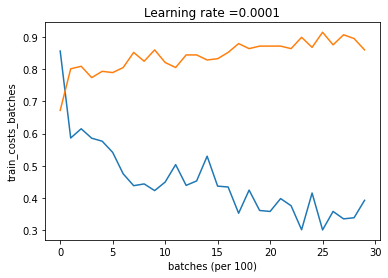

epoch,15
train loss,0.35177
train accuracy,0.88096
_runtime,141
_timestamp,1615561957
_step,29
val loss,0.3747
val accuracy,0.864


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇██████
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▄▃▃▂▂▂▂▁▁▁▁▁
val accuracy,▁▄▅▆▆▇▇▇▇█▇████


wandb: Agent Starting Run: sr1qrqex with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.485373369885449
val accuracy for epoch  1 =  0.8265
train cost for epoch  1 =  0.6685978689702274
train accuracy for epoch  1 =  0.7697222222222222

val cost for epoch  2 =  0.43222825155802475
val accuracy for epoch  2 =  0.8405
train cost for epoch  2 =  0.43632477582486806
train accuracy for epoch  2 =  0.8488888888888889

val cost for epoch  3 =  0.4194478731782442
val accuracy for epoch  3 =  0.8495
train cost for epoch  3 =  0.3972671878596102
train accuracy for epoch  3 =  0.8616296296296296

val cost for epoch  4 =  0.3826206882765625
val accuracy for epoch  4 =  0.8631666666666666
train cost for epoch  4 =  0.3689450917766714
train accuracy for epoch  4 =  0.8699444444444444

val cost for epoch  5 =  0.3740078597907481
val accuracy for epoch  5 =  0.865
train cost for epoch  5 =  0.35250223965427957
train accuracy for epoch  5 =  0.8775925925925926

val cost for epoch  6 =  0.3665881462487182
val accuracy for epoch  6 =  0.8705
train cost for epoch  

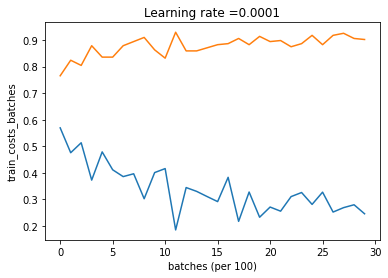

epoch,15
train loss,0.25926
train accuracy,0.90906
_runtime,121
_timestamp,1615562087
_step,29
val loss,0.32845
val accuracy,0.88383


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▃▂▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▆▆▆▇▇▇▇██████
_runtime,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▅▃▃▃▂▃▂▂▂▁▁▁▁
val accuracy,▁▃▄▅▆▆▆▆▆▇▇▇███


wandb: Agent Starting Run: dt2yno1i with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6589762273488392
val accuracy for epoch  1 =  0.7593333333333333
train cost for epoch  1 =  0.9587249594845351
train accuracy for epoch  1 =  0.6859074074074074

val cost for epoch  2 =  0.5571515153988271
val accuracy for epoch  2 =  0.8011666666666667
train cost for epoch  2 =  0.5843090671576712
train accuracy for epoch  2 =  0.8011481481481482

val cost for epoch  3 =  0.5045946313793235
val accuracy for epoch  3 =  0.8225
train cost for epoch  3 =  0.5151026518434513
train accuracy for epoch  3 =  0.8261851851851851

val cost for epoch  4 =  0.471715757966583
val accuracy for epoch  4 =  0.8361666666666666
train cost for epoch  4 =  0.4811981688099771
train accuracy for epoch  4 =  0.8387407407407408

val cost for epoch  5 =  0.46044142973801255
val accuracy for epoch  5 =  0.8383333333333334
train cost for epoch  5 =  0.45527869651735003
train accuracy for epoch  5 =  0.8475925925925926

val cost for epoch  6 =  0.4384389200349767
val accuracy for epoch

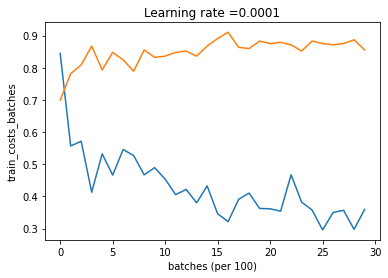

epoch,15
train loss,0.36488
train accuracy,0.87657
_runtime,140
_timestamp,1615562231
_step,29
val loss,0.38304
val accuracy,0.86517


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
train accuracy,▁▅▆▇▇▇▇▇███████
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
val accuracy,▁▄▅▆▆▇▇▇▇▇█████


wandb: Agent Starting Run: j7pxviwl with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 1
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.48002565690133225
val accuracy for epoch  1 =  0.8238333333333333
train cost for epoch  1 =  0.6102183421914374
train accuracy for epoch  1 =  0.7830925925925926

val cost for epoch  2 =  0.43784275409160295
val accuracy for epoch  2 =  0.8393333333333334
train cost for epoch  2 =  0.42874021418299885
train accuracy for epoch  2 =  0.8505185185185186

val cost for epoch  3 =  0.40064532994452806
val accuracy for epoch  3 =  0.8606666666666667
train cost for epoch  3 =  0.39275705948851913
train accuracy for epoch  3 =  0.8617222222222222

val cost for epoch  4 =  0.3769755276561975
val accuracy for epoch  4 =  0.8685
train cost for epoch  4 =  0.37297419895564105
train accuracy for epoch  4 =  0.8689074074074075

val cost for epoch  5 =  0.3774902029389795
val accuracy for epoch  5 =  0.865
train cost for epoch  5 =  0.3507370447332435
train accuracy for epoch  5 =  0.8747962962962963

val cost for epoch  6 =  0.3801565249689465
val accuracy for epoch  6 =  0

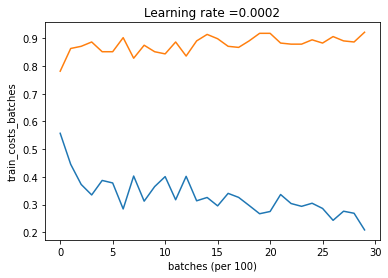

epoch,15
train loss,0.28016
train accuracy,0.89961
_runtime,116
_timestamp,1615562352
_step,29
val loss,0.37741
val accuracy,0.87183


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇███
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▄▂▂▃▂▃▂▁▂▂▂▂▂
val accuracy,▁▃▆▇▆▆▇▆▇█▇▇▇▇▇


wandb: Agent Starting Run: t4c1k6lo with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 1
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5769283081092538
val accuracy for epoch  1 =  0.7988333333333333
train cost for epoch  1 =  0.7946459271450138
train accuracy for epoch  1 =  0.7286666666666667

val cost for epoch  2 =  0.4906859240157033
val accuracy for epoch  2 =  0.8281666666666667
train cost for epoch  2 =  0.5226597894483328
train accuracy for epoch  2 =  0.8221666666666667

val cost for epoch  3 =  0.4606565417568253
val accuracy for epoch  3 =  0.8411666666666666
train cost for epoch  3 =  0.46510749068343993
train accuracy for epoch  3 =  0.8422222222222222

val cost for epoch  4 =  0.4232388589571798
val accuracy for epoch  4 =  0.8516666666666667
train cost for epoch  4 =  0.4310364830408633
train accuracy for epoch  4 =  0.8546851851851852

val cost for epoch  5 =  0.41651005472412167
val accuracy for epoch  5 =  0.8515
train cost for epoch  5 =  0.4064141445054898
train accuracy for epoch  5 =  0.8611666666666666

val cost for epoch  6 =  0.41580375877383463
val accuracy for epo

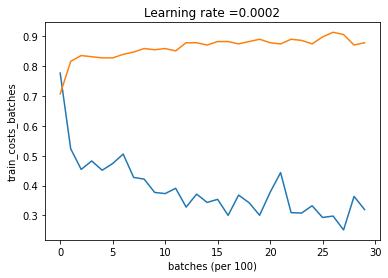

epoch,15
train loss,0.30903
train accuracy,0.89485
_runtime,140
_timestamp,1615562497
_step,29
val loss,0.35179
val accuracy,0.87733


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇▇█████
_runtime,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▃▃▃▂▂▂▁▁▂▁▁▁
val accuracy,▁▄▅▆▆▆▇▆▇▇▇▇███


wandb: Agent Starting Run: 6x6wyle5 with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.4560864438185768
val accuracy for epoch  1 =  0.8378333333333333
train cost for epoch  1 =  0.612938049382419
train accuracy for epoch  1 =  0.7815740740740741

val cost for epoch  2 =  0.41081871220522725
val accuracy for epoch  2 =  0.8505
train cost for epoch  2 =  0.42982811194044335
train accuracy for epoch  2 =  0.8484074074074074

val cost for epoch  3 =  0.40773454064691494
val accuracy for epoch  3 =  0.8493333333333334
train cost for epoch  3 =  0.3923737820837936
train accuracy for epoch  3 =  0.8600925925925926

val cost for epoch  4 =  0.392610415771726
val accuracy for epoch  4 =  0.858
train cost for epoch  4 =  0.36828546879849405
train accuracy for epoch  4 =  0.8696296296296296

val cost for epoch  5 =  0.3927093183947499
val accuracy for epoch  5 =  0.859
train cost for epoch  5 =  0.35299878016309366
train accuracy for epoch  5 =  0.8751481481481481

val cost for epoch  6 =  0.37427633045777803
val accuracy for epoch  6 =  0.862
train cost

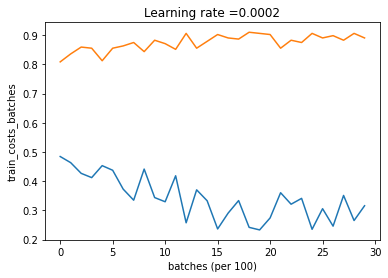

epoch,15
train loss,0.25736
train accuracy,0.90774
_runtime,116
_timestamp,1615562618
_step,29
val loss,0.33369
val accuracy,0.88067


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▄▃▃▃▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▅▆▆▇▇▇▇▇█████
_runtime,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▅▄▄▃▄▂▃▂▁▂▂▂▁
val accuracy,▁▃▃▄▄▅▅▆▅▇███▇█


wandb: Agent Starting Run: 2i1a5wgm with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5650140246676393
val accuracy for epoch  1 =  0.8046666666666666
train cost for epoch  1 =  0.7893443640817958
train accuracy for epoch  1 =  0.7299629629629629

val cost for epoch  2 =  0.5008287737661287
val accuracy for epoch  2 =  0.8168333333333333
train cost for epoch  2 =  0.5213742988640088
train accuracy for epoch  2 =  0.8226296296296296

val cost for epoch  3 =  0.4542348667025573
val accuracy for epoch  3 =  0.8385
train cost for epoch  3 =  0.46195663005308746
train accuracy for epoch  3 =  0.842925925925926

val cost for epoch  4 =  0.43376098977455657
val accuracy for epoch  4 =  0.844
train cost for epoch  4 =  0.42718833690063823
train accuracy for epoch  4 =  0.8541111111111112

val cost for epoch  5 =  0.4129962962549752
val accuracy for epoch  5 =  0.8511666666666666
train cost for epoch  5 =  0.4052285236005851
train accuracy for epoch  5 =  0.8615925925925926

val cost for epoch  6 =  0.3975144149351613
val accuracy for epoch  6 =  0.856

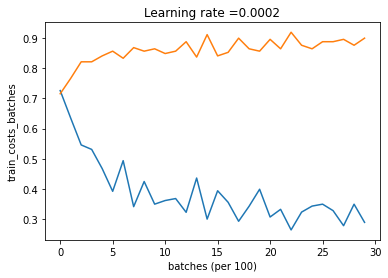

epoch,15
train loss,0.3177
train accuracy,0.89219
_runtime,139
_timestamp,1615562761
_step,29
val loss,0.35725
val accuracy,0.87517


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▄▄▃▂▂▂▂▁▁▁▁▁▁
val accuracy,▁▂▄▅▆▆▇▆▇▇█████


wandb: Agent Starting Run: elcrrjbq with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 1
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.4635768854369104
val accuracy for epoch  1 =  0.8288333333333333
train cost for epoch  1 =  0.6268480972534559
train accuracy for epoch  1 =  0.7838333333333334

val cost for epoch  2 =  0.39201448559330854
val accuracy for epoch  2 =  0.8601666666666666
train cost for epoch  2 =  0.42257441846970045
train accuracy for epoch  2 =  0.8528148148148148

val cost for epoch  3 =  0.37570405366668336
val accuracy for epoch  3 =  0.8675
train cost for epoch  3 =  0.3817038723539204
train accuracy for epoch  3 =  0.8652037037037037

val cost for epoch  4 =  0.3658431898849554
val accuracy for epoch  4 =  0.8645
train cost for epoch  4 =  0.35352490316419455
train accuracy for epoch  4 =  0.8746111111111111

val cost for epoch  5 =  0.36761768142585316
val accuracy for epoch  5 =  0.8668333333333333
train cost for epoch  5 =  0.33561174919666187
train accuracy for epoch  5 =  0.8816851851851852

val cost for epoch  6 =  0.35378461098266256
val accuracy for epoch  6 = 

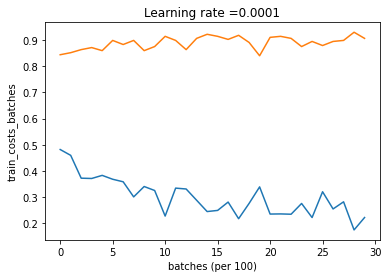

epoch,15
train loss,0.25214
train accuracy,0.91041
_runtime,221
_timestamp,1615562986
_step,29
val loss,0.33287
val accuracy,0.8825


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▆▆▆▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▄▄▃▃▂▂▂▂▂▂▂▂▁▁
val accuracy,▁▅▆▅▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: cw555lhn with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 1
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6062627848174573
val accuracy for epoch  1 =  0.7816666666666666
train cost for epoch  1 =  0.8645838303654009
train accuracy for epoch  1 =  0.7167037037037037

val cost for epoch  2 =  0.5257773450869495
val accuracy for epoch  2 =  0.8158333333333333
train cost for epoch  2 =  0.5431776662363452
train accuracy for epoch  2 =  0.815462962962963

val cost for epoch  3 =  0.47799776181718046
val accuracy for epoch  3 =  0.8331666666666667
train cost for epoch  3 =  0.48532777629923174
train accuracy for epoch  3 =  0.8368703703703704

val cost for epoch  4 =  0.4553367682320347
val accuracy for epoch  4 =  0.8395
train cost for epoch  4 =  0.4499725138317154
train accuracy for epoch  4 =  0.8484814814814815

val cost for epoch  5 =  0.4306797770589898
val accuracy for epoch  5 =  0.8471666666666666
train cost for epoch  5 =  0.4265558460262995
train accuracy for epoch  5 =  0.8558148148148148

val cost for epoch  6 =  0.4089692564875445
val accuracy for epoch

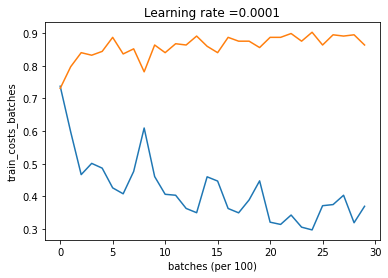

epoch,15
train loss,0.32488
train accuracy,0.88831
_runtime,257
_timestamp,1615563248
_step,29
val loss,0.36055
val accuracy,0.87333


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▄▄▃▂▂▂▂▂▁▁▁▁▁
val accuracy,▁▄▅▅▆▇▇▇▇▇█████


wandb: Agent Starting Run: 8qgtwryy with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.49601244996643984
val accuracy for epoch  1 =  0.8203333333333334
train cost for epoch  1 =  0.6285429000353496
train accuracy for epoch  1 =  0.7840370370370371

val cost for epoch  2 =  0.40002674102311114
val accuracy for epoch  2 =  0.8535
train cost for epoch  2 =  0.4243811874455071
train accuracy for epoch  2 =  0.853

val cost for epoch  3 =  0.38554881284986897
val accuracy for epoch  3 =  0.858
train cost for epoch  3 =  0.3822993795109247
train accuracy for epoch  3 =  0.8658888888888889

val cost for epoch  4 =  0.3830183794684609
val accuracy for epoch  4 =  0.86
train cost for epoch  4 =  0.35695586403191
train accuracy for epoch  4 =  0.8745740740740741

val cost for epoch  5 =  0.3601832628793795
val accuracy for epoch  5 =  0.8686666666666667
train cost for epoch  5 =  0.3368876626755679
train accuracy for epoch  5 =  0.8820370370370371

val cost for epoch  6 =  0.3420313562087456
val accuracy for epoch  6 =  0.8786666666666667
train cost for

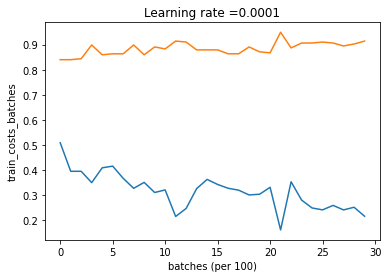

epoch,15
train loss,0.23918
train accuracy,0.91626
_runtime,221
_timestamp,1615563474
_step,29
val loss,0.3221
val accuracy,0.88933


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▄▃▃▃▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▅▆▆▆▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▄▄▃▃▂▂▂▂▁▁▁▁▁▁
val accuracy,▁▄▅▅▆▇▇▇▇█▇████


wandb: Agent Starting Run: yv3g86lm with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6008738843429666
val accuracy for epoch  1 =  0.791
train cost for epoch  1 =  0.8644847376613218
train accuracy for epoch  1 =  0.7181111111111111

val cost for epoch  2 =  0.5270672114727635
val accuracy for epoch  2 =  0.8193333333333334
train cost for epoch  2 =  0.5423888373489052
train accuracy for epoch  2 =  0.8162592592592592

val cost for epoch  3 =  0.4688871192542029
val accuracy for epoch  3 =  0.8381666666666666
train cost for epoch  3 =  0.48301423057535303
train accuracy for epoch  3 =  0.8375555555555556

val cost for epoch  4 =  0.44943840428882853
val accuracy for epoch  4 =  0.8405
train cost for epoch  4 =  0.44901836866168926
train accuracy for epoch  4 =  0.8492222222222222

val cost for epoch  5 =  0.4303774059331728
val accuracy for epoch  5 =  0.8495
train cost for epoch  5 =  0.42656567402278267
train accuracy for epoch  5 =  0.8550555555555556

val cost for epoch  6 =  0.4149818039478583
val accuracy for epoch  6 =  0.8523333333333

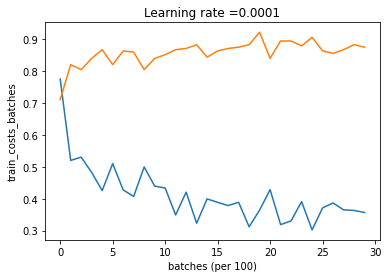

epoch,15
train loss,0.33757
train accuracy,0.88565
_runtime,264
_timestamp,1615563744
_step,29
val loss,0.36363
val accuracy,0.87167


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇███████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▄▄▃▃▂▂▂▂▁▁▁▁▁
val accuracy,▁▃▅▅▆▆▇▇▇██████


wandb: Agent Starting Run: 8omn5iii with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 1
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.487331613797986
val accuracy for epoch  1 =  0.828
train cost for epoch  1 =  0.5825524716713295
train accuracy for epoch  1 =  0.7950185185185186

val cost for epoch  2 =  0.42400464622747197
val accuracy for epoch  2 =  0.8418333333333333
train cost for epoch  2 =  0.4173192914986995
train accuracy for epoch  2 =  0.8522222222222222

val cost for epoch  3 =  0.38469615770263393
val accuracy for epoch  3 =  0.8595
train cost for epoch  3 =  0.3890955638121737
train accuracy for epoch  3 =  0.8623888888888889

val cost for epoch  4 =  0.3677677382493949
val accuracy for epoch  4 =  0.8685
train cost for epoch  4 =  0.36530716931209456
train accuracy for epoch  4 =  0.8688518518518519

val cost for epoch  5 =  0.3871689274062115
val accuracy for epoch  5 =  0.8598333333333333
train cost for epoch  5 =  0.3456699632947991
train accuracy for epoch  5 =  0.8775740740740741

val cost for epoch  6 =  0.3714051929659895
val accuracy for epoch  6 =  0.868166666666666

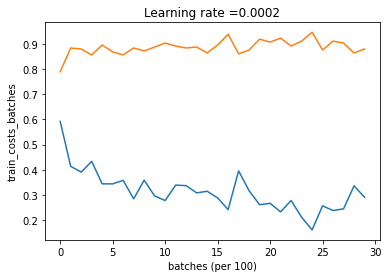

epoch,15
train loss,0.27165
train accuracy,0.90289
_runtime,214
_timestamp,1615563963
_step,29
val loss,0.35417
val accuracy,0.876


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▅▆▆▇▇▇▇▇▇▇███
_runtime,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▃▂▃▂▂▂▁▂▁▁▁▂▁
val accuracy,▁▃▅▇▅▆▆▆▇▆▇████


wandb: Agent Starting Run: jxndyawx with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 1
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5383183865030206
val accuracy for epoch  1 =  0.8158333333333333
train cost for epoch  1 =  0.727325932446838
train accuracy for epoch  1 =  0.7497962962962963

val cost for epoch  2 =  0.47308509754007394
val accuracy for epoch  2 =  0.8333333333333334
train cost for epoch  2 =  0.4921401686510569
train accuracy for epoch  2 =  0.8316111111111111

val cost for epoch  3 =  0.43358410349109205
val accuracy for epoch  3 =  0.8488333333333333
train cost for epoch  3 =  0.44043319071434206
train accuracy for epoch  3 =  0.849

val cost for epoch  4 =  0.4275206221894494
val accuracy for epoch  4 =  0.8501666666666666
train cost for epoch  4 =  0.40847970305668074
train accuracy for epoch  4 =  0.8597962962962963

val cost for epoch  5 =  0.39038922165667916
val accuracy for epoch  5 =  0.8615
train cost for epoch  5 =  0.384790075464094
train accuracy for epoch  5 =  0.8680740740740741

val cost for epoch  6 =  0.38720563860036034
val accuracy for epoch  6 =  0.8

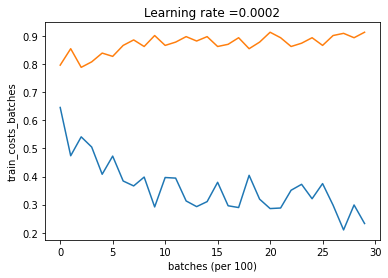

epoch,15
train loss,0.28861
train accuracy,0.90107
_runtime,270
_timestamp,1615564238
_step,29
val loss,0.35808
val accuracy,0.87


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▆▆▆▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇███
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▄▄▃▃▂▂▂▁▁▁▁▁▂
val accuracy,▁▃▅▅▆▆▇▇▇█████▇


wandb: Agent Starting Run: 3k2cmrdh with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.4535848004184122
val accuracy for epoch  1 =  0.8356666666666667
train cost for epoch  1 =  0.5843281562803355
train accuracy for epoch  1 =  0.7941851851851852

val cost for epoch  2 =  0.40023313489324563
val accuracy for epoch  2 =  0.857
train cost for epoch  2 =  0.4169222241097655
train accuracy for epoch  2 =  0.8522777777777778

val cost for epoch  3 =  0.38390589361445715
val accuracy for epoch  3 =  0.8586666666666667
train cost for epoch  3 =  0.3791394910221702
train accuracy for epoch  3 =  0.8658148148148148

val cost for epoch  4 =  0.38370166542118334
val accuracy for epoch  4 =  0.8645
train cost for epoch  4 =  0.3650783880552644
train accuracy for epoch  4 =  0.8701481481481481

val cost for epoch  5 =  0.38079090794201315
val accuracy for epoch  5 =  0.8631666666666666
train cost for epoch  5 =  0.34995504478485706
train accuracy for epoch  5 =  0.8756851851851852

val cost for epoch  6 =  0.35775867283078444
val accuracy for epoch  6 =  0

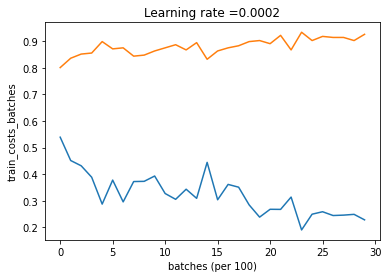

epoch,15
train loss,0.24581
train accuracy,0.91124
_runtime,223
_timestamp,1615564469
_step,29
val loss,0.33897
val accuracy,0.88617


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▅▄▃▃▃▃▂▂▂▁▁▁▁▁
train accuracy,▁▄▅▆▆▆▆▇▇▇█████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▄▄▃▃▃▄▃▂▁▁▁▁
val accuracy,▁▄▄▅▅▆▅▆▅▆▇▇▇██


wandb: Agent Starting Run: psy4s0g0 with config:
wandb: 	L2_regularization: 0.0005
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5420831575206744
val accuracy for epoch  1 =  0.8075
train cost for epoch  1 =  0.7313669871154906
train accuracy for epoch  1 =  0.7513703703703704

val cost for epoch  2 =  0.462121786187122
val accuracy for epoch  2 =  0.8393333333333334
train cost for epoch  2 =  0.494788643955021
train accuracy for epoch  2 =  0.8302962962962963

val cost for epoch  3 =  0.42706678551271277
val accuracy for epoch  3 =  0.85
train cost for epoch  3 =  0.4416105968899535
train accuracy for epoch  3 =  0.8491851851851852

val cost for epoch  4 =  0.41565452106426604
val accuracy for epoch  4 =  0.8531666666666666
train cost for epoch  4 =  0.4083593867084101
train accuracy for epoch  4 =  0.8593518518518518

val cost for epoch  5 =  0.3994491537611391
val accuracy for epoch  5 =  0.8578333333333333
train cost for epoch  5 =  0.38503827684680464
train accuracy for epoch  5 =  0.8673518518518518

val cost for epoch  6 =  0.38557367228209666
val accuracy for epoch  6 =  0.859


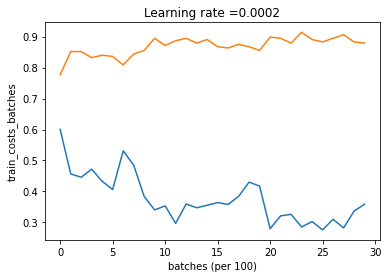

epoch,15
train loss,0.29046
train accuracy,0.89993
_runtime,271
_timestamp,1615564745
_step,29
val loss,0.33724
val accuracy,0.87983


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▃▂▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▆▆▆▇▇▇▇██████
_runtime,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▄▃▃▂▂▂▁▁▂▁▁▁
val accuracy,▁▄▅▅▆▆▆▇▇▇█▇███


wandb: Agent Starting Run: ahkx823d with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 1
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.4811293725787924
val accuracy for epoch  1 =  0.8231666666666667
train cost for epoch  1 =  0.6570214947122903
train accuracy for epoch  1 =  0.7755

val cost for epoch  2 =  0.4192522353555328
val accuracy for epoch  2 =  0.8461666666666666
train cost for epoch  2 =  0.43183085214765743
train accuracy for epoch  2 =  0.8517592592592592

val cost for epoch  3 =  0.38103359233056994
val accuracy for epoch  3 =  0.8581666666666666
train cost for epoch  3 =  0.38540358024902505
train accuracy for epoch  3 =  0.8666481481481482

val cost for epoch  4 =  0.3650889242031272
val accuracy for epoch  4 =  0.8668333333333333
train cost for epoch  4 =  0.3575952803187939
train accuracy for epoch  4 =  0.8760185185185185

val cost for epoch  5 =  0.35984084780541076
val accuracy for epoch  5 =  0.8685
train cost for epoch  5 =  0.3375867770018921
train accuracy for epoch  5 =  0.882537037037037

val cost for epoch  6 =  0.3560916091528815
val accuracy for epoch  6 =  0.8

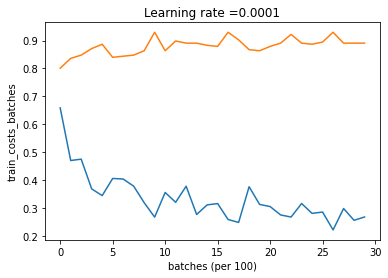

epoch,15
train loss,0.25155
train accuracy,0.91046
_runtime,132
_timestamp,1615564884
_step,29
val loss,0.33792
val accuracy,0.87617


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▃▃▂▂▁▂▂▁▁▁▂▂
val accuracy,▁▄▅▆▆▇▇█▇▇▇██▇▇


wandb: Agent Starting Run: 7k1ebwid with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 1
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6484893832523397
val accuracy for epoch  1 =  0.7708333333333334
train cost for epoch  1 =  0.9363437557177381
train accuracy for epoch  1 =  0.6995925925925925

val cost for epoch  2 =  0.5546755598323454
val accuracy for epoch  2 =  0.8021666666666667
train cost for epoch  2 =  0.5700780607056625
train accuracy for epoch  2 =  0.8080185185185185

val cost for epoch  3 =  0.5017088989417745
val accuracy for epoch  3 =  0.8265
train cost for epoch  3 =  0.5042147589733345
train accuracy for epoch  3 =  0.8312962962962963

val cost for epoch  4 =  0.47325719473797784
val accuracy for epoch  4 =  0.833
train cost for epoch  4 =  0.4698379973725722
train accuracy for epoch  4 =  0.8412962962962963

val cost for epoch  5 =  0.45586457132656544
val accuracy for epoch  5 =  0.8391666666666666
train cost for epoch  5 =  0.4457373662083909
train accuracy for epoch  5 =  0.8505555555555555

val cost for epoch  6 =  0.43688892208782654
val accuracy for epoch  6 =  0.84

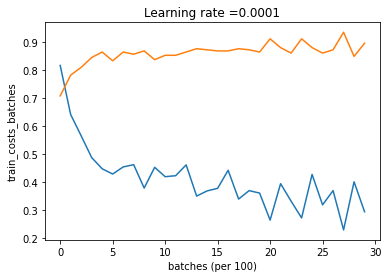

epoch,15
train loss,0.34078
train accuracy,0.88294
_runtime,146
_timestamp,1615565037
_step,29
val loss,0.36287
val accuracy,0.871


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇██████
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▄▄▃▃▃▂▂▂▂▁▂▁▁
val accuracy,▁▃▅▅▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: 8mohtfnc with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.47843391141622754
val accuracy for epoch  1 =  0.832
train cost for epoch  1 =  0.6584001434263163
train accuracy for epoch  1 =  0.773425925925926

val cost for epoch  2 =  0.41119675820098134
val accuracy for epoch  2 =  0.8518333333333333
train cost for epoch  2 =  0.43156431716342547
train accuracy for epoch  2 =  0.8506296296296296

val cost for epoch  3 =  0.3901357015064387
val accuracy for epoch  3 =  0.8625
train cost for epoch  3 =  0.38311237093960987
train accuracy for epoch  3 =  0.8673333333333333

val cost for epoch  4 =  0.3766657374926732
val accuracy for epoch  4 =  0.866
train cost for epoch  4 =  0.3587279038874789
train accuracy for epoch  4 =  0.8755555555555555

val cost for epoch  5 =  0.36283634497705614
val accuracy for epoch  5 =  0.8713333333333333
train cost for epoch  5 =  0.33919240388632815
train accuracy for epoch  5 =  0.8815185185185185

val cost for epoch  6 =  0.34556470470143913
val accuracy for epoch  6 =  0.876166666666

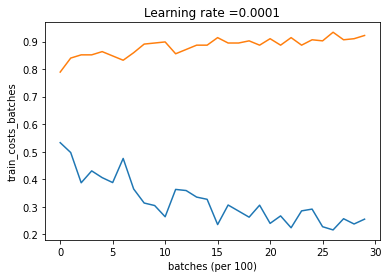

epoch,15
train loss,0.24387
train accuracy,0.91467
_runtime,123
_timestamp,1615565165
_step,29
val loss,0.31596
val accuracy,0.8865


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▃▂▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▆▆▆▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▄▃▂▃▂▂▁▁▁▁▁▁
val accuracy,▁▄▅▅▆▇▇▇▇██████


wandb: Agent Starting Run: od4ht2xk with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6483890654561569
val accuracy for epoch  1 =  0.7665
train cost for epoch  1 =  0.9491181500764099
train accuracy for epoch  1 =  0.6913888888888889

val cost for epoch  2 =  0.5486432225078035
val accuracy for epoch  2 =  0.8065
train cost for epoch  2 =  0.5769365548192261
train accuracy for epoch  2 =  0.8031111111111111

val cost for epoch  3 =  0.4964686711598246
val accuracy for epoch  3 =  0.8275
train cost for epoch  3 =  0.5090405564498164
train accuracy for epoch  3 =  0.8290555555555555

val cost for epoch  4 =  0.47225030396311307
val accuracy for epoch  4 =  0.8346666666666667
train cost for epoch  4 =  0.472201719977573
train accuracy for epoch  4 =  0.8411296296296297

val cost for epoch  5 =  0.4565174070667794
val accuracy for epoch  5 =  0.8413333333333334
train cost for epoch  5 =  0.44825299330681523
train accuracy for epoch  5 =  0.8498333333333333

val cost for epoch  6 =  0.4441908358873722
val accuracy for epoch  6 =  0.843666666666666

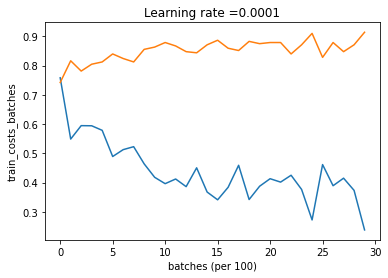

epoch,15
train loss,0.36008
train accuracy,0.87774
_runtime,137
_timestamp,1615565307
_step,29
val loss,0.38548
val accuracy,0.8615


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
train accuracy,▁▅▆▇▇▇▇▇███████
_runtime,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▃▃▃▂▂▂▂▁▁▁▁▁
val accuracy,▁▄▅▆▆▆▇▇▇▇█████


wandb: Agent Starting Run: vvh4egv3 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 1
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.43649172892239935
val accuracy for epoch  1 =  0.8423333333333334
train cost for epoch  1 =  0.6013417877411085
train accuracy for epoch  1 =  0.7877222222222222

val cost for epoch  2 =  0.38749895807445583
val accuracy for epoch  2 =  0.8653333333333333
train cost for epoch  2 =  0.4104931158731699
train accuracy for epoch  2 =  0.8558148148148148

val cost for epoch  3 =  0.3903246540090932
val accuracy for epoch  3 =  0.8533333333333334
train cost for epoch  3 =  0.372325999370658
train accuracy for epoch  3 =  0.8691666666666666

val cost for epoch  4 =  0.36445251420323127
val accuracy for epoch  4 =  0.8721666666666666
train cost for epoch  4 =  0.35515035247974036
train accuracy for epoch  4 =  0.8739629629629629

val cost for epoch  5 =  0.3763397090824417
val accuracy for epoch  5 =  0.8663333333333333
train cost for epoch  5 =  0.33498107889981255
train accuracy for epoch  5 =  0.8831666666666667

val cost for epoch  6 =  0.35287043421060404
val ac

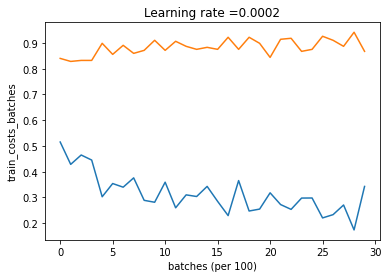

epoch,15
train loss,0.26177
train accuracy,0.9065
_runtime,118
_timestamp,1615565429
_step,29
val loss,0.36024
val accuracy,0.87583


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇██████
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▄▅▃▄▂▂▂▃▁▂▂▂▁▂
val accuracy,▁▅▃▆▅▇▇▇▆█▇▇▇█▇


wandb: Agent Starting Run: r19yo97q with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 1
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5616191640342242
val accuracy for epoch  1 =  0.8023333333333333
train cost for epoch  1 =  0.7696663463471312
train accuracy for epoch  1 =  0.74

val cost for epoch  2 =  0.4702231260753065
val accuracy for epoch  2 =  0.8321666666666667
train cost for epoch  2 =  0.505366686971322
train accuracy for epoch  2 =  0.8288888888888889

val cost for epoch  3 =  0.45162117812359215
val accuracy for epoch  3 =  0.843
train cost for epoch  3 =  0.45011399589935724
train accuracy for epoch  3 =  0.8460925925925926

val cost for epoch  4 =  0.42420785403547895
val accuracy for epoch  4 =  0.8476666666666667
train cost for epoch  4 =  0.41629652107315285
train accuracy for epoch  4 =  0.8585555555555555

val cost for epoch  5 =  0.3917904285119462
val accuracy for epoch  5 =  0.8626666666666667
train cost for epoch  5 =  0.39438938917909117
train accuracy for epoch  5 =  0.8654814814814815

val cost for epoch  6 =  0.38390762165634645
val accuracy for epoch  6 =  0.86

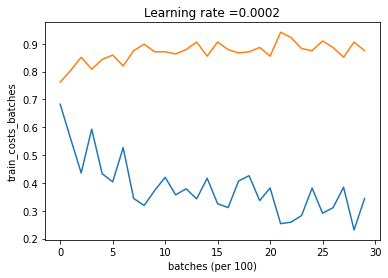

epoch,15
train loss,0.29984
train accuracy,0.89715
_runtime,136
_timestamp,1615565569
_step,29
val loss,0.34317
val accuracy,0.87617


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▄▃▂▂▂▂▁▁▁▁▁▁
val accuracy,▁▄▅▅▇▇▇▇▇▇█████


wandb: Agent Starting Run: 0bau50b6 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.44926166673232454
val accuracy for epoch  1 =  0.8431666666666666
train cost for epoch  1 =  0.6037791974286058
train accuracy for epoch  1 =  0.7886296296296297

val cost for epoch  2 =  0.4071858252344532
val accuracy for epoch  2 =  0.8525
train cost for epoch  2 =  0.4159028718243896
train accuracy for epoch  2 =  0.8535185185185186

val cost for epoch  3 =  0.39248819931805395
val accuracy for epoch  3 =  0.8545
train cost for epoch  3 =  0.37396043250105165
train accuracy for epoch  3 =  0.8692222222222222

val cost for epoch  4 =  0.3828211426179626
val accuracy for epoch  4 =  0.8603333333333333
train cost for epoch  4 =  0.35367257986479
train accuracy for epoch  4 =  0.8753518518518518

val cost for epoch  5 =  0.3639112560513883
val accuracy for epoch  5 =  0.8658333333333333
train cost for epoch  5 =  0.334577619161419
train accuracy for epoch  5 =  0.8835740740740741

val cost for epoch  6 =  0.37273723680875903
val accuracy for epoch  6 =  0.864

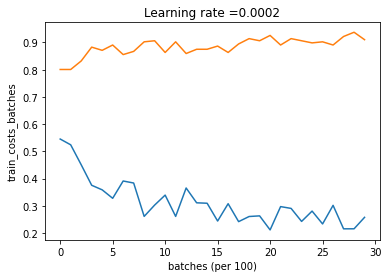

epoch,15
train loss,0.23855
train accuracy,0.91487
_runtime,116
_timestamp,1615565690
_step,29
val loss,0.33884
val accuracy,0.88283


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▄▃▃▃▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▅▆▆▆▇▇▇██████
_runtime,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▅▄▃▄▂▂▂▁▁▂▁▁▂
val accuracy,▁▃▃▄▅▅▆▇▇███▇██


wandb: Agent Starting Run: ea23h1lo with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5482780040302287
val accuracy for epoch  1 =  0.8056666666666666
train cost for epoch  1 =  0.7819520691346937
train accuracy for epoch  1 =  0.7367222222222222

val cost for epoch  2 =  0.47352177946524127
val accuracy for epoch  2 =  0.8321666666666667
train cost for epoch  2 =  0.5088888324663694
train accuracy for epoch  2 =  0.8268333333333333

val cost for epoch  3 =  0.4443699279172684
val accuracy for epoch  3 =  0.8403333333333334
train cost for epoch  3 =  0.45416269723697655
train accuracy for epoch  3 =  0.8465185185185186

val cost for epoch  4 =  0.4282917906991266
val accuracy for epoch  4 =  0.8446666666666667
train cost for epoch  4 =  0.4232395987893132
train accuracy for epoch  4 =  0.8571481481481481

val cost for epoch  5 =  0.40350046946310764
val accuracy for epoch  5 =  0.8568333333333333
train cost for epoch  5 =  0.4003033436555557
train accuracy for epoch  5 =  0.8631481481481481

val cost for epoch  6 =  0.39908801144888933
val acc

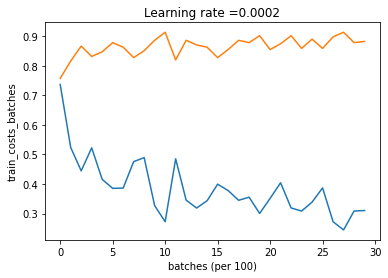

epoch,15
train loss,0.31025
train accuracy,0.89467
_runtime,138
_timestamp,1615565834
_step,29
val loss,0.35019
val accuracy,0.87167


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▄▃▃▂▂▂▂▁▁▁▁▁
val accuracy,▁▄▄▅▆▆▆▇▆▇███▇▇


wandb: Agent Starting Run: v5rt10qe with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 1
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.4635475040141174
val accuracy for epoch  1 =  0.833
train cost for epoch  1 =  0.6142161791609242
train accuracy for epoch  1 =  0.7896666666666666

val cost for epoch  2 =  0.3943194653673983
val accuracy for epoch  2 =  0.8615
train cost for epoch  2 =  0.4132142227428615
train accuracy for epoch  2 =  0.8561296296296297

val cost for epoch  3 =  0.37421509431071814
val accuracy for epoch  3 =  0.866
train cost for epoch  3 =  0.36965205639696186
train accuracy for epoch  3 =  0.8715555555555555

val cost for epoch  4 =  0.36695638638311895
val accuracy for epoch  4 =  0.8651666666666666
train cost for epoch  4 =  0.33903228229995086
train accuracy for epoch  4 =  0.880462962962963

val cost for epoch  5 =  0.3444995327229044
val accuracy for epoch  5 =  0.8748333333333334
train cost for epoch  5 =  0.32249929842635977
train accuracy for epoch  5 =  0.8866666666666667

val cost for epoch  6 =  0.36504406824592067
val accuracy for epoch  6 =  0.8705
train co

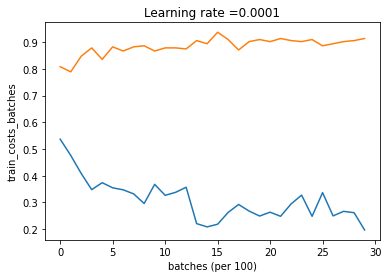

epoch,15
train loss,0.24015
train accuracy,0.91607
_runtime,220
_timestamp,1615566059
_step,29
val loss,0.33244
val accuracy,0.88567


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▆▆▆▇▇▇▇▇█████
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▃▂▃▂▂▂▁▁▁▁▁▂
val accuracy,▁▅▅▅▆▆▇▇▇██████


wandb: Agent Starting Run: qzjhzvwd with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 1
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5945033890541613
val accuracy for epoch  1 =  0.7968333333333333
train cost for epoch  1 =  0.8478183467506819
train accuracy for epoch  1 =  0.7261296296296297

val cost for epoch  2 =  0.516112254918878
val accuracy for epoch  2 =  0.822
train cost for epoch  2 =  0.5352381686699603
train accuracy for epoch  2 =  0.8190185185185185

val cost for epoch  3 =  0.4723367588454465
val accuracy for epoch  3 =  0.831
train cost for epoch  3 =  0.47783688523518186
train accuracy for epoch  3 =  0.8378333333333333

val cost for epoch  4 =  0.44197285716168694
val accuracy for epoch  4 =  0.843
train cost for epoch  4 =  0.4462386800212087
train accuracy for epoch  4 =  0.8507777777777777

val cost for epoch  5 =  0.4280923607464294
val accuracy for epoch  5 =  0.8488333333333333
train cost for epoch  5 =  0.42430138635154685
train accuracy for epoch  5 =  0.8570185185185185

val cost for epoch  6 =  0.41221758022756505
val accuracy for epoch  6 =  0.8541666666666666

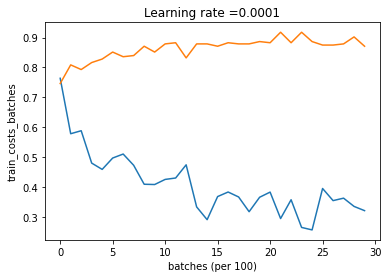

epoch,15
train loss,0.32121
train accuracy,0.89056
_runtime,258
_timestamp,1615566325
_step,29
val loss,0.35566
val accuracy,0.8735


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▄▄▃▃▃▂▂▂▁▁▁▁▁
val accuracy,▁▃▄▅▆▆▆▇▇▇█████


wandb: Agent Starting Run: 7ihopp1i with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.44336479909727305
val accuracy for epoch  1 =  0.8456666666666667
train cost for epoch  1 =  0.6182030185956479
train accuracy for epoch  1 =  0.7865925925925926

val cost for epoch  2 =  0.39290995247198746
val accuracy for epoch  2 =  0.8585
train cost for epoch  2 =  0.409171606183029
train accuracy for epoch  2 =  0.8583703703703703

val cost for epoch  3 =  0.39608419536764305
val accuracy for epoch  3 =  0.8543333333333333
train cost for epoch  3 =  0.3759997013364142
train accuracy for epoch  3 =  0.8682777777777778

val cost for epoch  4 =  0.35265141582054527
val accuracy for epoch  4 =  0.8735
train cost for epoch  4 =  0.34039049500543195
train accuracy for epoch  4 =  0.8810555555555556

val cost for epoch  5 =  0.3660395132179313
val accuracy for epoch  5 =  0.8705
train cost for epoch  5 =  0.32263558347657906
train accuracy for epoch  5 =  0.8865925925925926

val cost for epoch  6 =  0.34192013032277857
val accuracy for epoch  6 =  0.8776666666

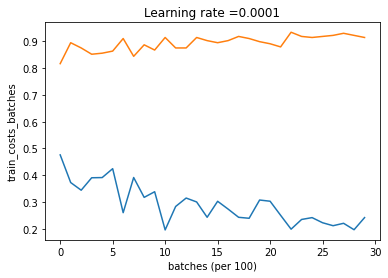

epoch,15
train loss,0.22176
train accuracy,0.92239
_runtime,219
_timestamp,1615566549
_step,29
val loss,0.3191
val accuracy,0.88867


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▄▃▃▃▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▅▆▆▆▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▆▃▄▃▃▃▂▂▂▂▁▁▂
val accuracy,▁▃▂▅▅▆▆▆▇▇▇████


wandb: Agent Starting Run: 1ltklt07 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6174772300722281
val accuracy for epoch  1 =  0.7753333333333333
train cost for epoch  1 =  0.8565913091707443
train accuracy for epoch  1 =  0.7161111111111111

val cost for epoch  2 =  0.515169217651338
val accuracy for epoch  2 =  0.8201666666666667
train cost for epoch  2 =  0.5362813137324153
train accuracy for epoch  2 =  0.819037037037037

val cost for epoch  3 =  0.47543904873655546
val accuracy for epoch  3 =  0.8321666666666667
train cost for epoch  3 =  0.47877034258430057
train accuracy for epoch  3 =  0.8389629629629629

val cost for epoch  4 =  0.44298704172114073
val accuracy for epoch  4 =  0.8461666666666666
train cost for epoch  4 =  0.4445014691450271
train accuracy for epoch  4 =  0.851574074074074

val cost for epoch  5 =  0.4276496612330511
val accuracy for epoch  5 =  0.847
train cost for epoch  5 =  0.4233350858471597
train accuracy for epoch  5 =  0.8569074074074075

val cost for epoch  6 =  0.4117361417255414
val accuracy for epoch  

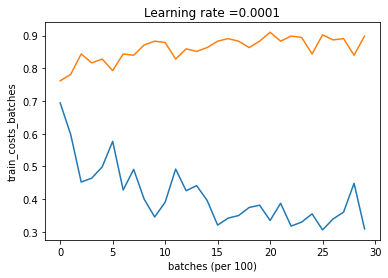

epoch,15
train loss,0.33117
train accuracy,0.88826
_runtime,256
_timestamp,1615566810
_step,29
val loss,0.3595
val accuracy,0.87067


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁
train accuracy,▁▅▆▇▇▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
val accuracy,▁▄▅▆▆▇▇▇▇██████


wandb: Agent Starting Run: q6tx38l5 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 1
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.40967454597561337
val accuracy for epoch  1 =  0.8486666666666667
train cost for epoch  1 =  0.5698483591641642
train accuracy for epoch  1 =  0.7985925925925926

val cost for epoch  2 =  0.38911473754970105
val accuracy for epoch  2 =  0.8583333333333333
train cost for epoch  2 =  0.4040683331881122
train accuracy for epoch  2 =  0.8570925925925926

val cost for epoch  3 =  0.39533149170119086
val accuracy for epoch  3 =  0.8593333333333333
train cost for epoch  3 =  0.3694763191177704
train accuracy for epoch  3 =  0.869037037037037

val cost for epoch  4 =  0.3617380555840071
val accuracy for epoch  4 =  0.871
train cost for epoch  4 =  0.34991411102776354
train accuracy for epoch  4 =  0.8755555555555555

val cost for epoch  5 =  0.367870550057052
val accuracy for epoch  5 =  0.8651666666666666
train cost for epoch  5 =  0.3312759864135429
train accuracy for epoch  5 =  0.8832777777777778

val cost for epoch  6 =  0.39566036804518295
val accuracy for epoc

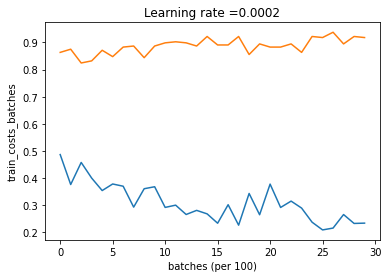

epoch,15
train loss,0.2532
train accuracy,0.91094
_runtime,215
_timestamp,1615567032
_step,29
val loss,0.33714
val accuracy,0.88317


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▅▆▆▇▇▇▇▇█████
_runtime,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▇▃▄▇▂▃▃▂▂▂▄▂▁
val accuracy,▁▃▃▆▄▄▇▆▅▇▆█▅▇█


wandb: Agent Starting Run: 3iqdagtl with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 1
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5258742049929439
val accuracy for epoch  1 =  0.8173333333333334
train cost for epoch  1 =  0.7187097016881069
train accuracy for epoch  1 =  0.7509259259259259

val cost for epoch  2 =  0.48000583515878936
val accuracy for epoch  2 =  0.8288333333333333
train cost for epoch  2 =  0.4896180613522681
train accuracy for epoch  2 =  0.8321851851851851

val cost for epoch  3 =  0.42652424147874757
val accuracy for epoch  3 =  0.849
train cost for epoch  3 =  0.4383627234317387
train accuracy for epoch  3 =  0.8517962962962963

val cost for epoch  4 =  0.40430398823921565
val accuracy for epoch  4 =  0.8573333333333333
train cost for epoch  4 =  0.4060829172869925
train accuracy for epoch  4 =  0.860537037037037

val cost for epoch  5 =  0.39057083499084494
val accuracy for epoch  5 =  0.8563333333333333
train cost for epoch  5 =  0.38009209234864205
train accuracy for epoch  5 =  0.8689629629629629

val cost for epoch  6 =  0.38294884554908937
val accuracy for ep

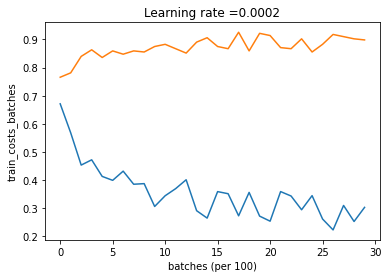

epoch,15
train loss,0.27933
train accuracy,0.90296
_runtime,262
_timestamp,1615567299
_step,29
val loss,0.33798
val accuracy,0.88217


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▆▆▆▇▇▇▇██████
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▄▄▃▃▂▂▂▂▁▁▁▁▁
val accuracy,▁▂▄▅▅▆▆▇▇██████


wandb: Agent Starting Run: xbzuqma0 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.45237879800331104
val accuracy for epoch  1 =  0.8331666666666667
train cost for epoch  1 =  0.5712442875801299
train accuracy for epoch  1 =  0.7985925925925926

val cost for epoch  2 =  0.39324492895348195
val accuracy for epoch  2 =  0.8548333333333333
train cost for epoch  2 =  0.40729157647245545
train accuracy for epoch  2 =  0.8553148148148149

val cost for epoch  3 =  0.37105429918945054
val accuracy for epoch  3 =  0.8635
train cost for epoch  3 =  0.36569175880186783
train accuracy for epoch  3 =  0.8707037037037038

val cost for epoch  4 =  0.37123119564481954
val accuracy for epoch  4 =  0.8598333333333333
train cost for epoch  4 =  0.3465648709547692
train accuracy for epoch  4 =  0.8774444444444445

val cost for epoch  5 =  0.36674664740220053
val accuracy for epoch  5 =  0.8656666666666667
train cost for epoch  5 =  0.3276186098141091
train accuracy for epoch  5 =  0.8823518518518518

val cost for epoch  6 =  0.36342521539053063
val accuracy fo

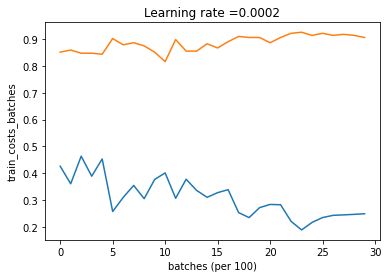

epoch,15
train loss,0.22396
train accuracy,0.921
_runtime,250
_timestamp,1615567554
_step,29
val loss,0.33648
val accuracy,0.887


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▅▄▃▃▃▃▃▂▂▁▁▁▁▁
train accuracy,▁▄▅▆▆▆▆▆▇▇█████
_runtime,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▃▃▃▃▄▃▂▁▁▁▂▁▁
val accuracy,▁▄▅▄▅▆▄▆▇▇██▇██


wandb: Agent Starting Run: 3p582n2w with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.8
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5410043893171759
val accuracy for epoch  1 =  0.8143333333333334
train cost for epoch  1 =  0.7222006629953096
train accuracy for epoch  1 =  0.7532962962962962

val cost for epoch  2 =  0.47832907758375354
val accuracy for epoch  2 =  0.8273333333333334
train cost for epoch  2 =  0.4884424059132552
train accuracy for epoch  2 =  0.8333518518518519

val cost for epoch  3 =  0.4236961528396661
val accuracy for epoch  3 =  0.8473333333333334
train cost for epoch  3 =  0.43861421332621414
train accuracy for epoch  3 =  0.8496851851851852

val cost for epoch  4 =  0.4112811478220916
val accuracy for epoch  4 =  0.8541666666666666
train cost for epoch  4 =  0.40485390678633154
train accuracy for epoch  4 =  0.8610740740740741

val cost for epoch  5 =  0.38554224141423726
val accuracy for epoch  5 =  0.8621666666666666
train cost for epoch  5 =  0.38103435446967526
train accuracy for epoch  5 =  0.8702222222222222

val cost for epoch  6 =  0.3776137716926803
val ac

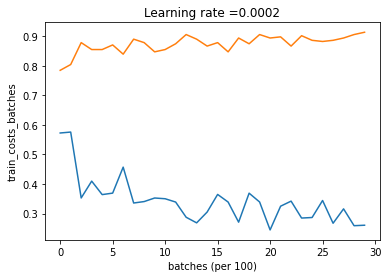

epoch,15
train loss,0.28714
train accuracy,0.90048
_runtime,265
_timestamp,1615567826
_step,29
val loss,0.33307
val accuracy,0.87833


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▃▂▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇██████
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▄▄▃▂▂▂▂▁▁▁▁▁▁
val accuracy,▁▂▄▅▆▇▆▇▇██████


wandb: Agent Starting Run: kaz5os79 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 1
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5074937184045626
val accuracy for epoch  1 =  0.8138333333333333
train cost for epoch  1 =  0.6753346243567517
train accuracy for epoch  1 =  0.7666481481481482

val cost for epoch  2 =  0.4433606294563391
val accuracy for epoch  2 =  0.8376666666666667
train cost for epoch  2 =  0.44029494533979535
train accuracy for epoch  2 =  0.8479814814814814

val cost for epoch  3 =  0.39466469462753695
val accuracy for epoch  3 =  0.8555
train cost for epoch  3 =  0.3962199390195181
train accuracy for epoch  3 =  0.8625925925925926

val cost for epoch  4 =  0.38421935693231807
val accuracy for epoch  4 =  0.8581666666666666
train cost for epoch  4 =  0.37021949061938675
train accuracy for epoch  4 =  0.8708703703703704

val cost for epoch  5 =  0.3779202688434833
val accuracy for epoch  5 =  0.8648333333333333
train cost for epoch  5 =  0.3507464409220719
train accuracy for epoch  5 =  0.8775185185185185

val cost for epoch  6 =  0.357450369121334
val accuracy for epo

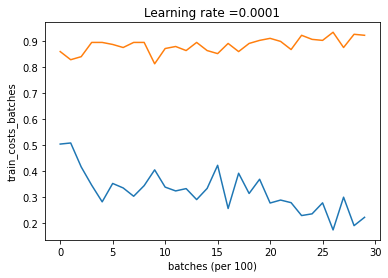

epoch,15
train loss,0.27111
train accuracy,0.90426
_runtime,122
_timestamp,1615567955
_step,29
val loss,0.35569
val accuracy,0.87183


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇▇█████
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▃▃▂▂▂▁▁▁▁▂▁▁▁
val accuracy,▁▄▅▆▆▇▇▇███▇█▇▇


wandb: Agent Starting Run: ry0idw41 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 1
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6696785359832612
val accuracy for epoch  1 =  0.7576666666666667
train cost for epoch  1 =  0.96438277594833
train accuracy for epoch  1 =  0.6844259259259259

val cost for epoch  2 =  0.5557373776069635
val accuracy for epoch  2 =  0.8051666666666667
train cost for epoch  2 =  0.5901615101172389
train accuracy for epoch  2 =  0.7992407407407407

val cost for epoch  3 =  0.5087052417874824
val accuracy for epoch  3 =  0.8211666666666667
train cost for epoch  3 =  0.5164730360640754
train accuracy for epoch  3 =  0.8273333333333334

val cost for epoch  4 =  0.47796373826620836
val accuracy for epoch  4 =  0.8323333333333334
train cost for epoch  4 =  0.4779255225899825
train accuracy for epoch  4 =  0.8388333333333333

val cost for epoch  5 =  0.46151611813921195
val accuracy for epoch  5 =  0.8351666666666666
train cost for epoch  5 =  0.4528412808909284
train accuracy for epoch  5 =  0.8475

val cost for epoch  6 =  0.4416737389078731
val accuracy for epoch 

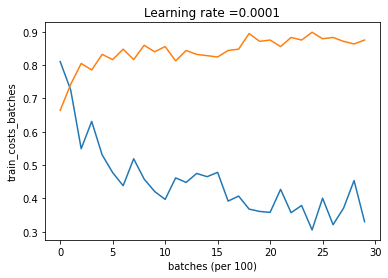

epoch,15
train loss,0.34816
train accuracy,0.88256
_runtime,148
_timestamp,1615568107
_step,29
val loss,0.37048
val accuracy,0.8645


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇██████
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▄▃▃▂▂▂▂▁▁▁▁▁
val accuracy,▁▄▅▆▆▇▇▇▇▇█████


wandb: Agent Starting Run: b2l89t5x with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.47476347913853
val accuracy for epoch  1 =  0.831
train cost for epoch  1 =  0.6632965578001041
train accuracy for epoch  1 =  0.7716851851851851

val cost for epoch  2 =  0.44131109942736746
val accuracy for epoch  2 =  0.8358333333333333
train cost for epoch  2 =  0.43523054482317
train accuracy for epoch  2 =  0.8495

val cost for epoch  3 =  0.3824804613946502
val accuracy for epoch  3 =  0.8618333333333333
train cost for epoch  3 =  0.39667934527621473
train accuracy for epoch  3 =  0.861462962962963

val cost for epoch  4 =  0.38154647757852506
val accuracy for epoch  4 =  0.8625
train cost for epoch  4 =  0.36930819083986877
train accuracy for epoch  4 =  0.870037037037037

val cost for epoch  5 =  0.38097434768237265
val accuracy for epoch  5 =  0.862
train cost for epoch  5 =  0.3473707536147196
train accuracy for epoch  5 =  0.8791296296296296

val cost for epoch  6 =  0.3709886481371196
val accuracy for epoch  6 =  0.866
train cost for epoch  6 =  

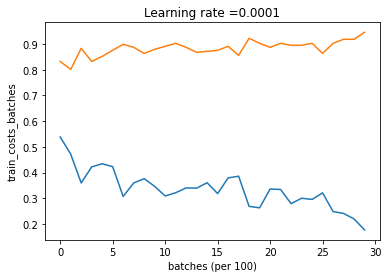

epoch,15
train loss,0.25674
train accuracy,0.90963
_runtime,123
_timestamp,1615568237
_step,29
val loss,0.33189
val accuracy,0.882


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▃▂▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▆▆▆▇▇▇▇██████
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▄▄▃▃▂▂▂▂▁▂▁▁▁
val accuracy,▁▂▅▅▅▅▆▇▆▇▇▇█▇▇


wandb: Agent Starting Run: c1ne89zb with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6663840574860413
val accuracy for epoch  1 =  0.7603333333333333
train cost for epoch  1 =  0.9516306408397708
train accuracy for epoch  1 =  0.6923703703703704

val cost for epoch  2 =  0.5525463313810733
val accuracy for epoch  2 =  0.8048333333333333
train cost for epoch  2 =  0.5791919834276837
train accuracy for epoch  2 =  0.8029259259259259

val cost for epoch  3 =  0.5061652637170506
val accuracy for epoch  3 =  0.8251666666666667
train cost for epoch  3 =  0.5114217720719381
train accuracy for epoch  3 =  0.8283703703703704

val cost for epoch  4 =  0.4662699663305764
val accuracy for epoch  4 =  0.8343333333333334
train cost for epoch  4 =  0.47166157833369443
train accuracy for epoch  4 =  0.8413888888888889

val cost for epoch  5 =  0.4580477558322219
val accuracy for epoch  5 =  0.8365
train cost for epoch  5 =  0.44667112950979115
train accuracy for epoch  5 =  0.8496111111111111

val cost for epoch  6 =  0.441361174504143
val accuracy for epoch

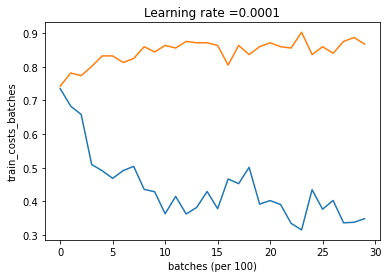

epoch,15
train loss,0.35778
train accuracy,0.87767
_runtime,146
_timestamp,1615568388
_step,29
val loss,0.38056
val accuracy,0.8665


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
train accuracy,▁▅▆▇▇▇▇▇███████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
val accuracy,▁▄▅▆▆▆▇▇██▇████


wandb: Agent Starting Run: 3oj93rvf with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 1
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.47651588405631273
val accuracy for epoch  1 =  0.8273333333333334
train cost for epoch  1 =  0.6092171858757846
train accuracy for epoch  1 =  0.784074074074074

val cost for epoch  2 =  0.4445813468370242
val accuracy for epoch  2 =  0.8365
train cost for epoch  2 =  0.4266707133221511
train accuracy for epoch  2 =  0.8491296296296297

val cost for epoch  3 =  0.388217570592149
val accuracy for epoch  3 =  0.8588333333333333
train cost for epoch  3 =  0.39223965090733354
train accuracy for epoch  3 =  0.8602222222222222

val cost for epoch  4 =  0.4035381693968619
val accuracy for epoch  4 =  0.8541666666666666
train cost for epoch  4 =  0.37182154679638735
train accuracy for epoch  4 =  0.8694444444444445

val cost for epoch  5 =  0.3771845523301669
val accuracy for epoch  5 =  0.8621666666666666
train cost for epoch  5 =  0.3584442518082749
train accuracy for epoch  5 =  0.8718148148148148

val cost for epoch  6 =  0.3703751322300074
val accuracy for epoch

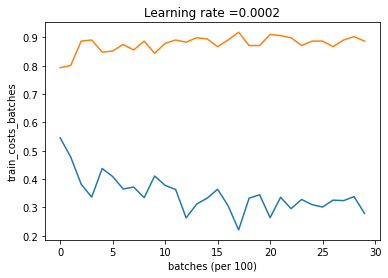

epoch,15
train loss,0.28184
train accuracy,0.89933
_runtime,121
_timestamp,1615568516
_step,29
val loss,0.38906
val accuracy,0.86567


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁
train accuracy,▁▅▆▆▆▇▇▇▇▇▇████
_runtime,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▃▄▂▂▁▂▁▁▃▁▁▂▃
val accuracy,▁▂▅▅▆▆▇▇█▇▆▇█▇▆


wandb: Agent Starting Run: 40oen9bt with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 1
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5756257462583719
val accuracy for epoch  1 =  0.796
train cost for epoch  1 =  0.7897130326118298
train accuracy for epoch  1 =  0.7313148148148149

val cost for epoch  2 =  0.4937295310422228
val accuracy for epoch  2 =  0.8258333333333333
train cost for epoch  2 =  0.5185889726001927
train accuracy for epoch  2 =  0.8253333333333334

val cost for epoch  3 =  0.4720488961648926
val accuracy for epoch  3 =  0.8295
train cost for epoch  3 =  0.45904417244429113
train accuracy for epoch  3 =  0.8445370370370371

val cost for epoch  4 =  0.43315714908244163
val accuracy for epoch  4 =  0.846
train cost for epoch  4 =  0.4272288815450095
train accuracy for epoch  4 =  0.8546851851851852

val cost for epoch  5 =  0.4094140165724308
val accuracy for epoch  5 =  0.8533333333333334
train cost for epoch  5 =  0.4025564963172572
train accuracy for epoch  5 =  0.8632407407407408

val cost for epoch  6 =  0.4035835361560354
val accuracy for epoch  6 =  0.8543333333333333

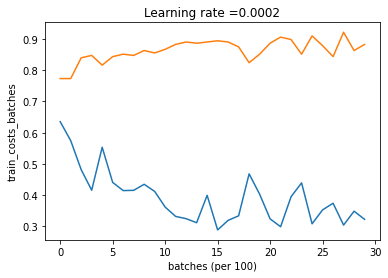

epoch,15
train loss,0.30801
train accuracy,0.89452
_runtime,145
_timestamp,1615568666
_step,29
val loss,0.34816
val accuracy,0.87533


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▅▄▃▃▂▂▂▂▂▁▁▁▁
val accuracy,▁▄▄▅▆▆▇▇▇▇▇████


wandb: Agent Starting Run: yq42qzhc with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.45527475518193367
val accuracy for epoch  1 =  0.8338333333333333
train cost for epoch  1 =  0.6110319573641786
train accuracy for epoch  1 =  0.7855925925925926

val cost for epoch  2 =  0.4371143623491894
val accuracy for epoch  2 =  0.8415
train cost for epoch  2 =  0.42560590349638405
train accuracy for epoch  2 =  0.8500740740740741

val cost for epoch  3 =  0.39963898426538874
val accuracy for epoch  3 =  0.8511666666666666
train cost for epoch  3 =  0.3865427578020621
train accuracy for epoch  3 =  0.8617222222222222

val cost for epoch  4 =  0.3921131751846725
val accuracy for epoch  4 =  0.8636666666666667
train cost for epoch  4 =  0.37070318294746984
train accuracy for epoch  4 =  0.869537037037037

val cost for epoch  5 =  0.38485759297799077
val accuracy for epoch  5 =  0.8611666666666666
train cost for epoch  5 =  0.3553223448161487
train accuracy for epoch  5 =  0.8747407407407407

val cost for epoch  6 =  0.36561904557339076
val accuracy for e

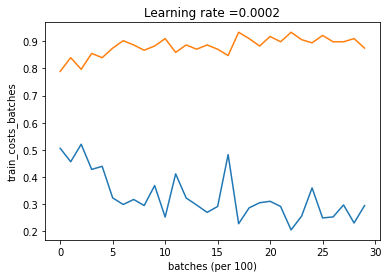

epoch,15
train loss,0.25881
train accuracy,0.90857
_runtime,122
_timestamp,1615568793
_step,29
val loss,0.33686
val accuracy,0.88417


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▄▃▃▃▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▅▆▆▆▇▇▇▇█████
_runtime,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▇▅▄▄▃▄▃▃▂▁▁▂▂▁
val accuracy,▁▂▃▅▅▆▅▆▆▇▇█▇▇█


wandb: Agent Starting Run: 1k6nwsle with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 256
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5785107116421704
val accuracy for epoch  1 =  0.8
train cost for epoch  1 =  0.786687644742696
train accuracy for epoch  1 =  0.733037037037037

val cost for epoch  2 =  0.4978526250482352
val accuracy for epoch  2 =  0.8203333333333334
train cost for epoch  2 =  0.5211511602239892
train accuracy for epoch  2 =  0.8221666666666667

val cost for epoch  3 =  0.45077015656939645
val accuracy for epoch  3 =  0.8421666666666666
train cost for epoch  3 =  0.46339105611937653
train accuracy for epoch  3 =  0.8439444444444445

val cost for epoch  4 =  0.42774774708366015
val accuracy for epoch  4 =  0.8478333333333333
train cost for epoch  4 =  0.4296256888400955
train accuracy for epoch  4 =  0.855

val cost for epoch  5 =  0.4113904762289314
val accuracy for epoch  5 =  0.8531666666666666
train cost for epoch  5 =  0.40686599120749173
train accuracy for epoch  5 =  0.8615185185185186

val cost for epoch  6 =  0.4089190482449903
val accuracy for epoch  6 =  0.857666

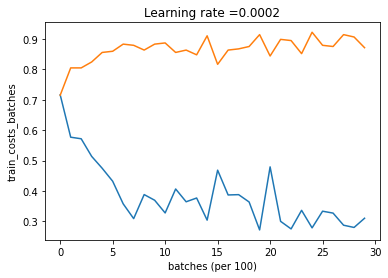

epoch,15
train loss,0.31768
train accuracy,0.89191
_runtime,150
_timestamp,1615568950
_step,29
val loss,0.35675
val accuracy,0.87217


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇██████
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▄▃▃▃▂▂▂▂▂▁▁▁▁
val accuracy,▁▃▅▅▆▆▆▇▇▇▇████


wandb: Agent Starting Run: 01pz1nu8 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 1
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.44978398547325726
val accuracy for epoch  1 =  0.8378333333333333
train cost for epoch  1 =  0.624801480993124
train accuracy for epoch  1 =  0.7817037037037037

val cost for epoch  2 =  0.42439174798259
val accuracy for epoch  2 =  0.8455
train cost for epoch  2 =  0.41932004042385423
train accuracy for epoch  2 =  0.8547777777777777

val cost for epoch  3 =  0.39987317005167416
val accuracy for epoch  3 =  0.8558333333333333
train cost for epoch  3 =  0.38026041445125175
train accuracy for epoch  3 =  0.8667222222222222

val cost for epoch  4 =  0.37562187944009323
val accuracy for epoch  4 =  0.8701666666666666
train cost for epoch  4 =  0.3560578395200216
train accuracy for epoch  4 =  0.8746851851851852

val cost for epoch  5 =  0.37602083249106166
val accuracy for epoch  5 =  0.8635
train cost for epoch  5 =  0.3366279736506842
train accuracy for epoch  5 =  0.8821481481481481

val cost for epoch  6 =  0.33870529633409
val accuracy for epoch  6 =  0.872

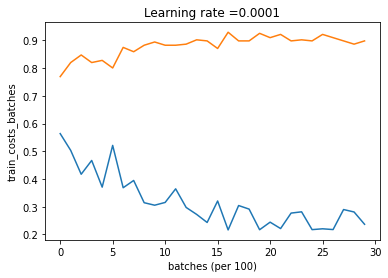

epoch,15
train loss,0.25254
train accuracy,0.91013
_runtime,257
_timestamp,1615569212
_step,29
val loss,0.34075
val accuracy,0.878


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▆▆▆▇▇▇▇▇█████
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▅▃▃▁▂▂▂▁▁▁▁▁▁
val accuracy,▁▂▄▆▅▇▇▇▇▇█▇▇█▇


wandb: Agent Starting Run: a2xw8xoq with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 1
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6024406879906802
val accuracy for epoch  1 =  0.7875
train cost for epoch  1 =  0.8645199532390354
train accuracy for epoch  1 =  0.7183148148148149

val cost for epoch  2 =  0.5100749191912476
val accuracy for epoch  2 =  0.8228333333333333
train cost for epoch  2 =  0.5415001456855577
train accuracy for epoch  2 =  0.8158888888888889

val cost for epoch  3 =  0.4762937138260427
val accuracy for epoch  3 =  0.835
train cost for epoch  3 =  0.48345109809511627
train accuracy for epoch  3 =  0.8365925925925926

val cost for epoch  4 =  0.4579550939024405
val accuracy for epoch  4 =  0.838
train cost for epoch  4 =  0.45230310804570845
train accuracy for epoch  4 =  0.8468888888888889

val cost for epoch  5 =  0.4289022740690019
val accuracy for epoch  5 =  0.8481666666666666
train cost for epoch  5 =  0.4285050003763363
train accuracy for epoch  5 =  0.8554259259259259

val cost for epoch  6 =  0.41652383118945907
val accuracy for epoch  6 =  0.854666666666666

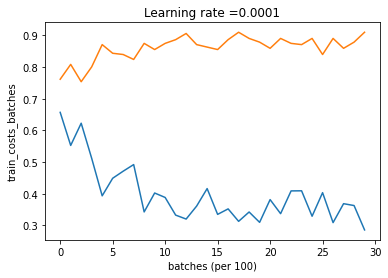

epoch,15
train loss,0.32854
train accuracy,0.88843
_runtime,315
_timestamp,1615569532
_step,29
val loss,0.35264
val accuracy,0.87433


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇▇█████
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▁
val accuracy,▁▄▅▅▆▆▆▇▇▇▇█▇▇█


wandb: Agent Starting Run: rzu3m9sz with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.4501247018458163
val accuracy for epoch  1 =  0.8351666666666666
train cost for epoch  1 =  0.621335492279043
train accuracy for epoch  1 =  0.7865185185185185

val cost for epoch  2 =  0.4118938648867433
val accuracy for epoch  2 =  0.8486666666666667
train cost for epoch  2 =  0.42399450955740253
train accuracy for epoch  2 =  0.8530740740740741

val cost for epoch  3 =  0.3915281826338077
val accuracy for epoch  3 =  0.8588333333333333
train cost for epoch  3 =  0.3819415974709088
train accuracy for epoch  3 =  0.8674074074074074

val cost for epoch  4 =  0.37056224508150687
val accuracy for epoch  4 =  0.8576666666666667
train cost for epoch  4 =  0.3530445070268708
train accuracy for epoch  4 =  0.8757777777777778

val cost for epoch  5 =  0.35042246316541
val accuracy for epoch  5 =  0.8698333333333333
train cost for epoch  5 =  0.3367785954009623
train accuracy for epoch  5 =  0.8813148148148148

val cost for epoch  6 =  0.37801019175930356
val accurac

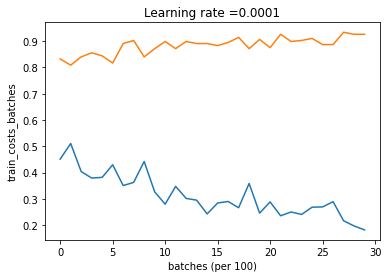

epoch,15
train loss,0.23825
train accuracy,0.91669
_runtime,263
_timestamp,1615569800
_step,29
val loss,0.32721
val accuracy,0.88417


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▄▃▃▃▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▅▆▆▆▇▇▇▇█████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▅▄▃▄▃▃▂▁▁▁▁▂▁
val accuracy,▁▃▄▄▆▄▆▅▆██████


wandb: Agent Starting Run: 1ware4q8 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0001
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.6084097475503262
val accuracy for epoch  1 =  0.7845
train cost for epoch  1 =  0.8692504902184405
train accuracy for epoch  1 =  0.7142407407407407

val cost for epoch  2 =  0.5286921561982192
val accuracy for epoch  2 =  0.8148333333333333
train cost for epoch  2 =  0.5427888696785534
train accuracy for epoch  2 =  0.8164444444444444

val cost for epoch  3 =  0.48848690634548114
val accuracy for epoch  3 =  0.824
train cost for epoch  3 =  0.4833990373122047
train accuracy for epoch  3 =  0.8372777777777778

val cost for epoch  4 =  0.4553513932009017
val accuracy for epoch  4 =  0.8391666666666666
train cost for epoch  4 =  0.4505299779111762
train accuracy for epoch  4 =  0.8472037037037037

val cost for epoch  5 =  0.43261159417907175
val accuracy for epoch  5 =  0.845
train cost for epoch  5 =  0.42689762760488337
train accuracy for epoch  5 =  0.8549814814814815

val cost for epoch  6 =  0.4159828086629667
val accuracy for epoch  6 =  0.8525
train cost

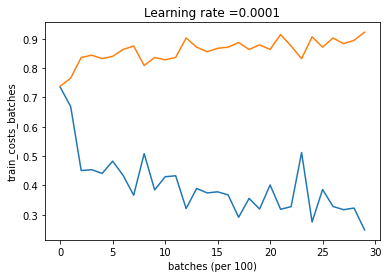

epoch,15
train loss,0.33639
train accuracy,0.88691
_runtime,306
_timestamp,1615570111
_step,29
val loss,0.36594
val accuracy,0.86733


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇██████
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁
val accuracy,▁▃▄▅▆▇▇▇▇██████


wandb: Agent Starting Run: br3mydm8 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 1
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.44491494319611
val accuracy for epoch  1 =  0.8398333333333333
train cost for epoch  1 =  0.5874853070379832
train accuracy for epoch  1 =  0.7934814814814815

val cost for epoch  2 =  0.40590180559644334
val accuracy for epoch  2 =  0.8475
train cost for epoch  2 =  0.41467157362391555
train accuracy for epoch  2 =  0.8546481481481482

val cost for epoch  3 =  0.40364482683030306
val accuracy for epoch  3 =  0.8531666666666666
train cost for epoch  3 =  0.3831725462957412
train accuracy for epoch  3 =  0.8652592592592593

val cost for epoch  4 =  0.3780219847818981
val accuracy for epoch  4 =  0.8595
train cost for epoch  4 =  0.36637256515254496
train accuracy for epoch  4 =  0.8705

val cost for epoch  5 =  0.3701773048579353
val accuracy for epoch  5 =  0.8625
train cost for epoch  5 =  0.3494295662412433
train accuracy for epoch  5 =  0.8767777777777778

val cost for epoch  6 =  0.3700710605905655
val accuracy for epoch  6 =  0.8628333333333333
train cos

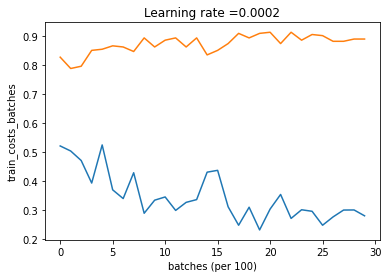

epoch,15
train loss,0.27607
train accuracy,0.90191
_runtime,246
_timestamp,1615570364
_step,29
val loss,0.35288
val accuracy,0.87683


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▆▆▆▇▇▇▇▇▇████
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▅▃▂▂▂▂▃▂▂▂▃▂▁
val accuracy,▁▂▄▅▅▅▇▆▆▅▇▇▇▇█


wandb: Agent Starting Run: x6xqfp1f with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 1
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.547121766323261
val accuracy for epoch  1 =  0.8086666666666666
train cost for epoch  1 =  0.7347998035014902
train accuracy for epoch  1 =  0.7479259259259259

val cost for epoch  2 =  0.46261218959624034
val accuracy for epoch  2 =  0.838
train cost for epoch  2 =  0.49300030639098874
train accuracy for epoch  2 =  0.8324444444444444

val cost for epoch  3 =  0.42851190925291543
val accuracy for epoch  3 =  0.8461666666666666
train cost for epoch  3 =  0.43894967387187717
train accuracy for epoch  3 =  0.850925925925926

val cost for epoch  4 =  0.4103680643876235
val accuracy for epoch  4 =  0.8548333333333333
train cost for epoch  4 =  0.40584281983967657
train accuracy for epoch  4 =  0.8605185185185186

val cost for epoch  5 =  0.4006662665244672
val accuracy for epoch  5 =  0.856
train cost for epoch  5 =  0.38504347388813637
train accuracy for epoch  5 =  0.8677592592592592

val cost for epoch  6 =  0.38887320623083727
val accuracy for epoch  6 =  0.8

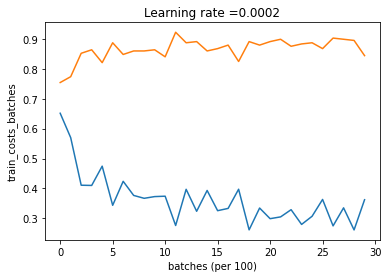

epoch,15
train loss,0.29029
train accuracy,0.89815
_runtime,306
_timestamp,1615570675
_step,29
val loss,0.33435
val accuracy,0.8805


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇██████
_runtime,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▄▄▃▃▂▂▂▁▂▁▁▁▁
val accuracy,▁▄▅▅▆▆▇▇▇█▇████


wandb: Agent Starting Run: 6uayn1p0 with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: adam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.4373358056208281
val accuracy for epoch  1 =  0.8411666666666666
train cost for epoch  1 =  0.5883968676022593
train accuracy for epoch  1 =  0.7916296296296297

val cost for epoch  2 =  0.39800540567490256
val accuracy for epoch  2 =  0.8543333333333333
train cost for epoch  2 =  0.41354517216229486
train accuracy for epoch  2 =  0.853537037037037

val cost for epoch  3 =  0.4068473484256908
val accuracy for epoch  3 =  0.8465
train cost for epoch  3 =  0.3829448270820137
train accuracy for epoch  3 =  0.8641296296296296

val cost for epoch  4 =  0.3869984771596995
val accuracy for epoch  4 =  0.861
train cost for epoch  4 =  0.36197716336247043
train accuracy for epoch  4 =  0.8726481481481482

val cost for epoch  5 =  0.3780767084131014
val accuracy for epoch  5 =  0.8618333333333333
train cost for epoch  5 =  0.34913004405724424
train accuracy for epoch  5 =  0.8763333333333333

val cost for epoch  6 =  0.3790496157948874
val accuracy for epoch  6 =  0.85

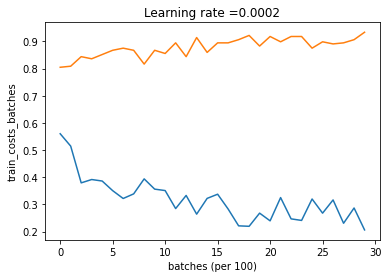

epoch,15
train loss,0.24797
train accuracy,0.9122
_runtime,252
_timestamp,1615570932
_step,29
val loss,0.34246
val accuracy,0.88283


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▄▃▃▃▃▂▂▂▁▁▁▁▁
train accuracy,▁▅▅▆▆▆▆▇▇▇█████
_runtime,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇███
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▅▆▅▄▄▃▄▃▂▂▁▂▁▂
val accuracy,▁▃▂▄▄▄▅▅▅▇▆▇▇█▇


wandb: Agent Starting Run: vvrebxhz with config:
wandb: 	L2_regularization: 0.05
wandb: 	activation_fns: relu
wandb: 	batch_size: 256
wandb: 	dropout: 0.7
wandb: 	epochs: 15
wandb: 	hidden_layers_config: 512
wandb: 	learning_rate: 0.0002
wandb: 	lr_schedule: 0.5
wandb: 	optimizer: nadam
wandb: 	weight_initialization: xavier


val cost for epoch  1 =  0.5325410539939037
val accuracy for epoch  1 =  0.8155
train cost for epoch  1 =  0.7268794273616217
train accuracy for epoch  1 =  0.7508888888888889

val cost for epoch  2 =  0.46695964721982014
val accuracy for epoch  2 =  0.8345
train cost for epoch  2 =  0.4955807160810923
train accuracy for epoch  2 =  0.830574074074074

val cost for epoch  3 =  0.42643848889205194
val accuracy for epoch  3 =  0.8456666666666667
train cost for epoch  3 =  0.4369155751303093
train accuracy for epoch  3 =  0.8513148148148149

val cost for epoch  4 =  0.41378997809465673
val accuracy for epoch  4 =  0.8525
train cost for epoch  4 =  0.4069207024710739
train accuracy for epoch  4 =  0.8607407407407407

val cost for epoch  5 =  0.393735196935847
val accuracy for epoch  5 =  0.8613333333333333
train cost for epoch  5 =  0.3851544321207481
train accuracy for epoch  5 =  0.8673703703703703

val cost for epoch  6 =  0.37849876006803373
val accuracy for epoch  6 =  0.86266666666666

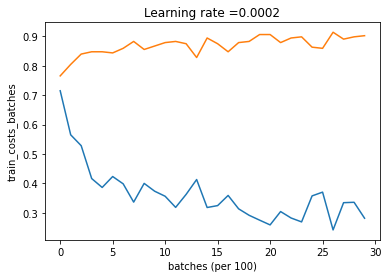

epoch,15
train loss,0.29273
train accuracy,0.89883
_runtime,306
_timestamp,1615571243
_step,29
val loss,0.33604
val accuracy,0.88033


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
train accuracy,▁▅▆▆▇▇▇▇▇██████
_runtime,▁▁▁▁▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▁▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
val loss,█▆▄▄▃▃▂▂▁▁▁▁▁▁▁
val accuracy,▁▃▄▅▆▆▇▇▇████▇█


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [11]:
wandb.agent(sweep_id, sp_train)